In [54]:
import os
import math
import random
import datetime
import numpy as np
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

from skopt import load
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.callbacks import CheckpointSaver
from skopt.space import Integer, Real, Categorical

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import Callback
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.layers.experimental import preprocessing

from swish import Swish
from SoftmaxCosineSim import SoftmaxCosineSim

In [55]:
batch_size = 8
img_height = 224
img_width = 224
num_classes = 7

In [56]:
random.seed(42)

image_feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

def one_hot_encode_label(image, label):
    label = tf.one_hot(label, num_classes)

    return image, label

def preprocces_image_pretrained(example_proto):
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image.set_shape([img_width*img_width])
    image = tf.reshape(image, (img_width, img_width, 1))
    image = tf.image.grayscale_to_rgb(image)
    
    label = tf.cast(features['label'], tf.int32)
    
    return image, label

def preprocces_image_custom(example_proto):
    features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.decode_raw(features['image'], tf.uint8)
    image.set_shape([img_width*img_width])
    image = tf.reshape(image, (img_width, img_width, 1))
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    
    label = tf.cast(features['label'], tf.int32)
    
    return image, label

def read_dataset(batch_size, filenames, map_funcs = [], repeat=True, drop_remainder=False, shuffle=True):
    dataset = tf.data.TFRecordDataset(filenames)
    
    for func in map_funcs:
        dataset = dataset.map(func, tf.data.experimental.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=20 * batch_size, seed = 42)
    if repeat:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

man_annot_tfrecord_dir = os.path.join("AffectNet", "120GB", "Manually_Annotated_compressed", "AffectNet_Manually_Annotated_Images_224x224_tfrecords")
man_annot_tfrecord_files = sorted(os.listdir(man_annot_tfrecord_dir))
man_annot_tfrecord_paths = [os.path.join(man_annot_tfrecord_dir, file) for file in man_annot_tfrecord_files]

tfrecord_paths = man_annot_tfrecord_paths

num_shards_for_val_set = 6
num_shards_for_test_set = 6
num_of_imgs_per_shard = 3500
total_num_of_imgs = 230855

val_ds_num_of_imgs = num_of_imgs_per_shard * num_shards_for_val_set
test_ds_num_of_imgs = num_of_imgs_per_shard * num_shards_for_test_set
train_ds_num_of_imgs = total_num_of_imgs - val_ds_num_of_imgs - test_ds_num_of_imgs

val_tfrecord_paths = tfrecord_paths[:num_shards_for_val_set]
test_tfrecord_paths = tfrecord_paths[num_shards_for_val_set:num_shards_for_val_set+num_shards_for_test_set]
train_tfrecord_paths = tfrecord_paths[num_shards_for_val_set+num_shards_for_test_set:]
random.shuffle(train_tfrecord_paths)

map_funcs = [preprocces_image_pretrained, one_hot_encode_label]

train_ds = read_dataset(batch_size, train_tfrecord_paths, map_funcs=map_funcs)
val_ds = read_dataset(batch_size, val_tfrecord_paths, map_funcs=map_funcs, repeat=False, shuffle=False)
test_ds = read_dataset(batch_size, test_tfrecord_paths, map_funcs=map_funcs, repeat=False, shuffle=False)

print("A total of {} images, {} train, {} validation, {} test.".format(total_num_of_imgs, train_ds_num_of_imgs, val_ds_num_of_imgs, test_ds_num_of_imgs))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
A total of 230855 images, 188855 train, 21000 validation, 21000 test.


In [9]:
def build_model_pretrained(layer_sizes, dropout_rates):
    file_path = "AffectNet/120GB/SimCLRv1/models/new/base_model/base_model_efficientnet_color_distort_true_crop_true_flip_true_blur_true_more_data.h5"
    simclr = load_model(file_path, custom_objects={"Swish": Swish, "SoftmaxCosineSim": SoftmaxCosineSim})
    
    img_augmentation = Sequential(
        [
            preprocessing.RandomRotation(factor=0.15),
            preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
            preprocessing.RandomFlip(mode="horizontal"),
            preprocessing.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    layer = img_augmentation(inputs)
    layer = simclr(layer)
    
    layer = layers.GlobalAveragePooling2D(name="avg_pool")(layer)
    layer = layers.BatchNormalization()(layer)
    
    for layer_size, dropout_rate in zip(layer_sizes, dropout_rates):
        layer = layers.Dense(layer_size)(layer)#, activation="relu")(layer)
        layer = layers.BatchNormalization()(layer)
        layer = layers.ReLU()(layer)
        layer = layers.Dropout(dropout_rate)(layer)
    
    outputs = layers.Dense(num_classes, activation="softmax")(layer)
    
    model = Model(inputs, outputs)
    return model

model = build_model_pretrained([709], [0.297])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 709)               908229    
_________________________________________________________________
batch_normalization_1 (Batch (None, 709)               2836  

In [4]:
def build_model_without_self_sup_base(layer_sizes, dropout_rates):
    efficient_net = EfficientNetB0(include_top=False, weights='imagenet')
    img_augmentation = Sequential(
        [
            preprocessing.RandomRotation(factor=0.15),
            preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
            preprocessing.RandomFlip(mode="horizontal"),
            preprocessing.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    layer = img_augmentation(inputs)
    layer = efficient_net(layer)
    
    layer = layers.GlobalAveragePooling2D(name="avg_pool")(layer)
    layer = layers.BatchNormalization()(layer)
    
    for layer_size, dropout_rate in zip(layer_sizes, dropout_rates):
        layer = layers.Dense(layer_size)(layer)#, activation="relu")(layer)
        layer = layers.BatchNormalization()(layer)
        layer = layers.ReLU()(layer)
        layer = layers.Dropout(dropout_rate)(layer)
    
    outputs = layers.Dense(num_classes, activation="softmax")(layer)
    
    model = Model(inputs, outputs)
    return model

model = build_model_without_self_sup_base([709], [0.297])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 709)               908229    
_________________________________________________________________
batch_normalization_1 (Batch (None, 709)               2836  

In [28]:
model_path = os.path.join("final_model", "second_run", "model_3_0.8455620408058167.h5")
model = load_model(model_path, custom_objects={"Swish": Swish, "SoftmaxCosineSim": SoftmaxCosineSim})

In [5]:
def unfreeze_model(model, num_layers):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return model

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    model.layers[-1].trainable = True
    return model


# model = freeze_model(model)
model = unfreeze_model(model, 10)

In [6]:
# train_ds_doesnt_repeat = read_dataset(batch_size, train_tfrecord_paths, map_funcs=map_funcs, repeat=False)
# batch_y_correct = [y for x, y in train_ds_doesnt_repeat]
# y_correct = []
# for batch in batch_y_correct:
#     y_correct.extend(batch)
# y_correct = np.argmax(y_correct, axis=1)

# class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_correct), y=y_correct)
# class_weight = {l:c for l,c in zip(np.unique(y_correct), class_weight)}

class_weight = {0: 0.5423190020560769, 1: 0.2922461270869473, 2: 1.7390283430634081, 3: 3.1647255969836614, 4: 7.068191174819417, 5: 10.770173937838608, 6: 1.6421745519682096}

print(class_weight)

{0: 0.5423190020560769, 1: 0.2922461270869473, 2: 1.7390283430634081, 3: 3.1647255969836614, 4: 7.068191174819417, 5: 10.770173937838608, 6: 1.6421745519682096}


In [7]:
train_ds_doesnt_repeat = read_dataset(batch_size, train_tfrecord_paths, map_funcs=map_funcs, repeat=False)

class Metrics(Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data
        self.val_y_correct = self.calculate_correct_y()
        self.labels = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "angry"]
        
    def on_epoch_end(self, epoch, logs={}):
        save_name = "model_" + str(epoch) + "_" + str(logs["val_loss"]) + ".h5"
        save_path = os.path.join(self.save_dir, save_name)
        model.save(save_path)
        
        y_pred = self.model.predict(self.validation_data)
        y_pred = np.argmax(y_pred, axis=1)
        _val_f1 = f1_score(self.val_y_correct, y_pred, average="macro")
        _val_recall = recall_score(self.val_y_correct, y_pred, average="macro")
        _val_precision = precision_score(self.val_y_correct, y_pred, average="macro")
        
        print("Calculating training loss")
        train_loss = self.model.evaluate(train_ds_doesnt_repeat)
        
        logs["train_loss"] = train_loss
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        
        with open(os.path.join(self.save_dir, "hist.txt"), "a") as f:
            f.write(str(logs) + "\n")
        
        print(colored(" — val_f1: {:.5f} — val_precision: {:.5f} — val_recall: {:.5f} — ".format(_val_f1, _val_precision, _val_recall), "red", attrs=["bold"]))
        print(classification_report(self.val_y_correct, y_pred, target_names=self.labels, digits=3))
        print(colored("Non-normalized", attrs=["bold"]))
        self.print_confusion_matrix(y_pred, None)
        print(colored("Normalized by true", attrs=["bold"]))
        self.print_confusion_matrix(y_pred, "true")
        print(colored("Normalized by prediction", attrs=["bold"]))
        self.print_confusion_matrix(y_pred, "pred")
        
    def calculate_correct_y(self):
        batch_val_y_correct = [y for x, y in self.validation_data]
        val_y_correct = []
        for batch in batch_val_y_correct:
            val_y_correct.extend(batch)
        val_y_correct = np.argmax(val_y_correct, axis=1)
        return val_y_correct
    
    def print_confusion_matrix(self, y_pred, normalize=None):
        conf_matrix = confusion_matrix(self.val_y_correct, y_pred, normalize=normalize)
        plt.figure()
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                if normalize:
                    value = "{:.3f}".format(conf_matrix[i, j])
                else:
                    value = format(conf_matrix[i, j])
                plt.text(j, i, value,
                            ha="center", va="center",
                             color="white" if conf_matrix[i, j] == 0 else "black")
        plt.tight_layout()
        plt.colorbar()
        plt.show()

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000267)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy"
)

In [9]:
metrics = Metrics(valid_data=val_ds)
metrics.save_dir = os.path.join("final_model")

In [12]:
steps_per_epoch = math.ceil(train_ds_num_of_imgs / batch_size) # One full epoch

epochs = 40
hist = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, class_weight=class_weight, validation_data=val_ds, verbose=1, batch_size=batch_size, callbacks=[metrics])

Resuming from checkpoints/checkpoint.pkl.
Num of layers: 1
Layer of size: 1730 with dropout rate of 0.30594335963878905.
With a learning rate of 3.131674344405911e-05.
With 12 layers unfrozen.
And a batch size of 32.
---
Epoch 1/5
2188/2188 [==============================] - 474s 214ms/step - loss: 1.7726 - val_loss: 1.2536
Calculating training loss
1094/1094 [==============================] - 83s 75ms/step - loss: 1.2548
 — val_f1: 0.36318 — val_precision: 0.36823 — val_recall: 0.45943 — 
              precision    recall  f1-score   support

     neutral      0.592     0.436     0.502      3597
       happy      0.938     0.685     0.792      6929
         sad      0.285     0.249     0.266      1172
    surprise      0.183     0.474     0.264       643
        fear      0.156     0.513     0.239       308
     disgust      0.066     0.489     0.116       186
       angry      0.358     0.370     0.364      1165

    accuracy                          0.542     14000
   macro avg     

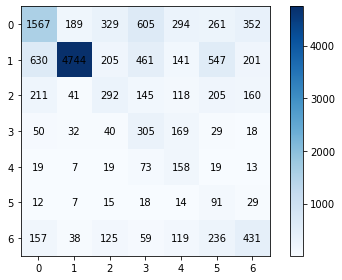

Normalized by true


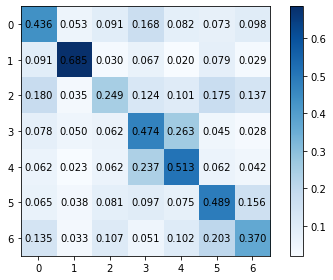

Normalized by prediction


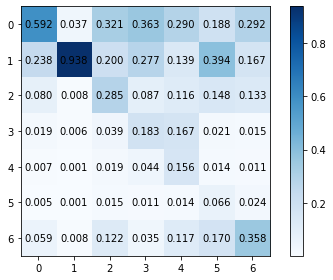

Epoch 2/5
2188/2188 [==============================] - 465s 212ms/step - loss: 1.3969 - val_loss: 1.1625
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1569
 — val_f1: 0.40019 — val_precision: 0.40069 — val_recall: 0.50878 — 
              precision    recall  f1-score   support

     neutral      0.630     0.470     0.538      3597
       happy      0.964     0.711     0.818      6929
         sad      0.344     0.384     0.363      1172
    surprise      0.273     0.317     0.294       643
        fear      0.155     0.623     0.249       308
     disgust      0.077     0.602     0.137       186
       angry      0.362     0.453     0.402      1165

    accuracy                          0.579     14000
   macro avg      0.401     0.509     0.400     14000
weighted avg      0.715     0.579     0.628     14000

Non-normalized


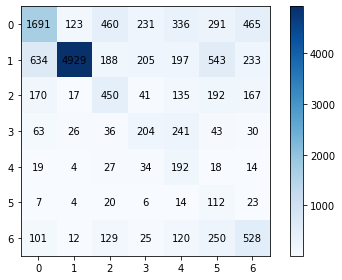

Normalized by true


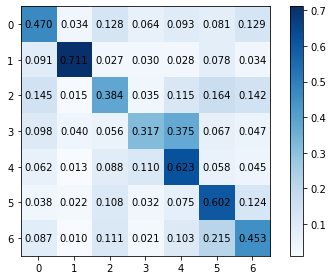

Normalized by prediction


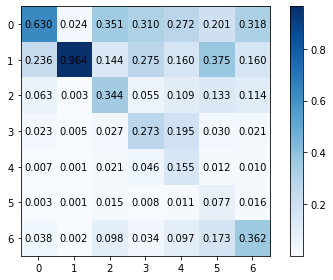

Epoch 3/5
2188/2188 [==============================] - 465s 212ms/step - loss: 1.2709 - val_loss: 1.1250
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.1084
 — val_f1: 0.42213 — val_precision: 0.41184 — val_recall: 0.52799 — 
              precision    recall  f1-score   support

     neutral      0.622     0.477     0.540      3597
       happy      0.968     0.695     0.809      6929
         sad      0.368     0.462     0.410      1172
    surprise      0.295     0.389     0.336       643
        fear      0.171     0.562     0.263       308
     disgust      0.087     0.548     0.150       186
       angry      0.371     0.562     0.447      1165

    accuracy                          0.590     14000
   macro avg      0.412     0.528     0.422     14000
weighted avg      0.719     0.590     0.634     14000

Non-normalized


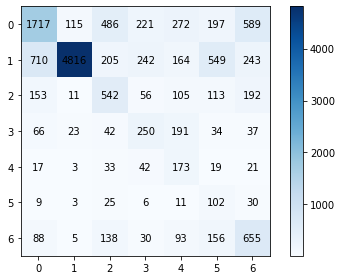

Normalized by true


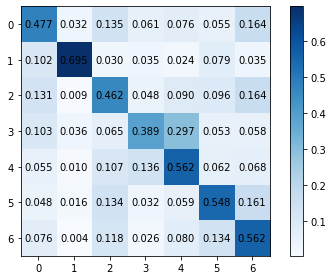

Normalized by prediction


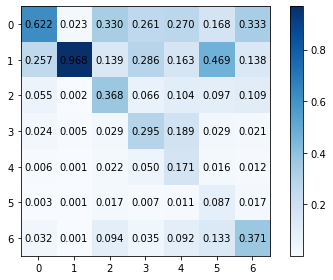

Epoch 4/5
2188/2188 [==============================] - 464s 212ms/step - loss: 1.1779 - val_loss: 1.0982
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0659
 — val_f1: 0.43122 — val_precision: 0.41757 — val_recall: 0.54250 — 
              precision    recall  f1-score   support

     neutral      0.627     0.479     0.543      3597
       happy      0.972     0.712     0.822      6929
         sad      0.395     0.449     0.420      1172
    surprise      0.241     0.533     0.332       643
        fear      0.174     0.555     0.265       308
     disgust      0.108     0.548     0.180       186
       angry      0.407     0.521     0.457      1165

    accuracy                          0.600     14000
   macro avg      0.418     0.543     0.431     14000
weighted avg      0.725     0.600     0.643     14000

Non-normalized


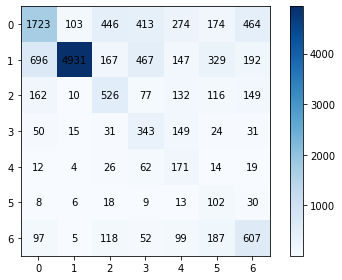

Normalized by true


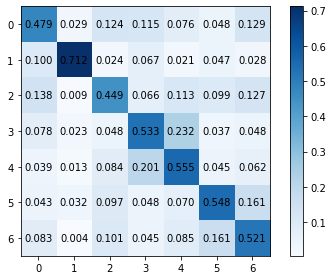

Normalized by prediction


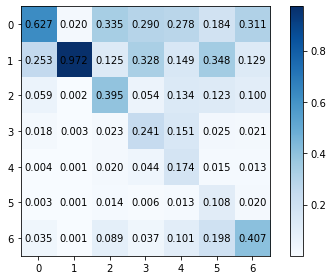

Epoch 5/5
2188/2188 [==============================] - 464s 212ms/step - loss: 1.1265 - val_loss: 1.0652
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.0238
 — val_f1: 0.43404 — val_precision: 0.42434 — val_recall: 0.55021 — 
              precision    recall  f1-score   support

     neutral      0.649     0.438     0.523      3597
       happy      0.964     0.746     0.841      6929
         sad      0.376     0.514     0.434      1172
    surprise      0.243     0.504     0.328       643
        fear      0.171     0.581     0.265       308
     disgust      0.107     0.597     0.182       186
       angry      0.460     0.472     0.466      1165

    accuracy                          0.608     14000
   macro avg      0.424     0.550     0.434     14000
weighted avg      0.730     0.608     0.649     14000

Non-normalized


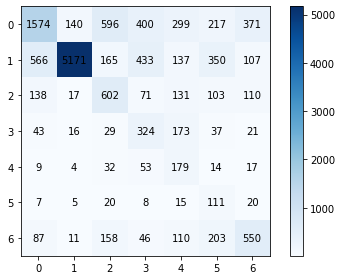

Normalized by true


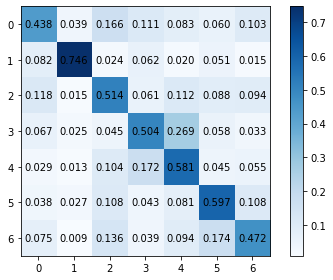

Normalized by prediction


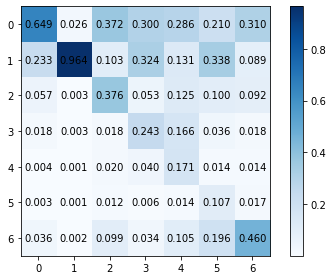

Num of layers: 1
Layer of size: 963 with dropout rate of 0.34484514753225426.
With a learning rate of 0.0008857201682474254.
With 18 layers unfrozen.
And a batch size of 16.
---
Epoch 1/5
4375/4375 [==============================] - 524s 118ms/step - loss: 1.7937 - val_loss: 1.2599
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.2605
 — val_f1: 0.37696 — val_precision: 0.38751 — val_recall: 0.41190 — 
              precision    recall  f1-score   support

     neutral      0.490     0.745     0.591      3597
       happy      0.941     0.596     0.730      6929
         sad      0.295     0.216     0.249      1172
    surprise      0.226     0.348     0.274       643
        fear      0.240     0.344     0.283       308
     disgust      0.051     0.242     0.084       186
       angry      0.470     0.392     0.428      1165

    accuracy                          0.564     14000
   macro avg      0.388     0.412     0.377     14000
weight

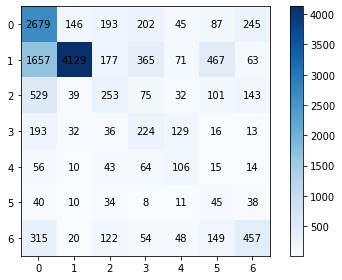

Normalized by true


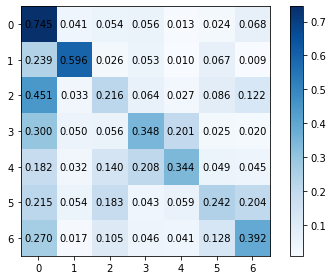

Normalized by prediction


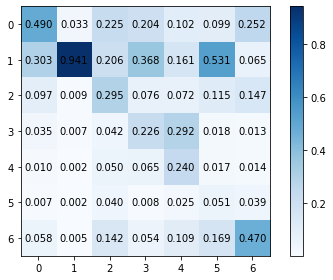

Epoch 2/5
4375/4375 [==============================] - 515s 118ms/step - loss: 1.4953 - val_loss: 0.9176
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 0.9208
 — val_f1: 0.42035 — val_precision: 0.44951 — val_recall: 0.44893 — 
              precision    recall  f1-score   support

     neutral      0.613     0.620     0.617      3597
       happy      0.905     0.840     0.872      6929
         sad      0.335     0.422     0.374      1172
    surprise      0.254     0.582     0.353       643
        fear      0.344     0.182     0.238       308
     disgust      0.140     0.290     0.189       186
       angry      0.556     0.206     0.301      1165

    accuracy                          0.662     14000
   macro avg      0.450     0.449     0.420     14000
weighted avg      0.701     0.662     0.670     14000

Non-normalized


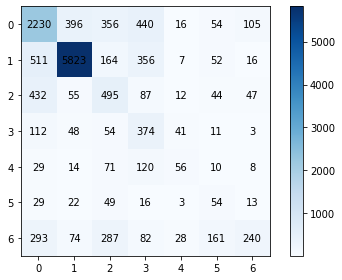

Normalized by true


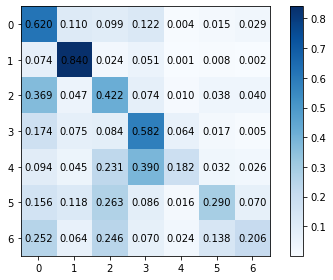

Normalized by prediction


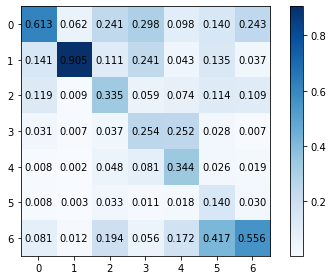

Epoch 3/5
4375/4375 [==============================] - 515s 118ms/step - loss: 1.4027 - val_loss: 1.4652
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.4669
 — val_f1: 0.30987 — val_precision: 0.45532 — val_recall: 0.43418 — 
              precision    recall  f1-score   support

     neutral      0.635     0.243     0.352      3597
       happy      0.971     0.582     0.728      6929
         sad      0.435     0.293     0.350      1172
    surprise      0.131     0.734     0.223       643
        fear      0.283     0.305     0.294       308
     disgust      0.041     0.801     0.078       186
       angry      0.691     0.081     0.145      1165

    accuracy                          0.433     14000
   macro avg      0.455     0.434     0.310     14000
weighted avg      0.750     0.433     0.510     14000

Non-normalized


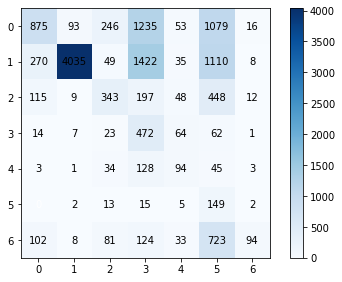

Normalized by true


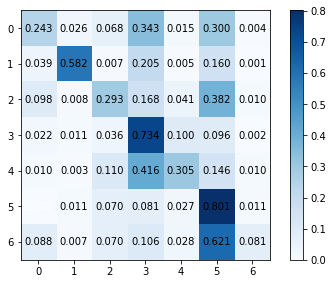

Normalized by prediction


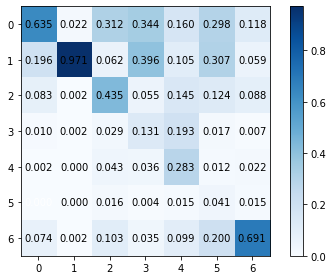

Epoch 4/5
4375/4375 [==============================] - 518s 118ms/step - loss: 1.3430 - val_loss: 1.0428
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0427
 — val_f1: 0.39673 — val_precision: 0.45508 — val_recall: 0.47556 — 
              precision    recall  f1-score   support

     neutral      0.661     0.459     0.542      3597
       happy      0.925     0.812     0.865      6929
         sad      0.325     0.605     0.423      1172
    surprise      0.240     0.510     0.326       643
        fear      0.323     0.354     0.338       308
     disgust      0.067     0.495     0.119       186
       angry      0.643     0.094     0.165      1165

    accuracy                          0.616     14000
   macro avg      0.455     0.476     0.397     14000
weighted avg      0.728     0.616     0.640     14000

Non-normalized


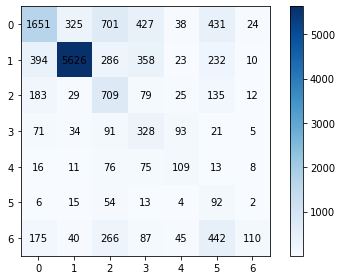

Normalized by true


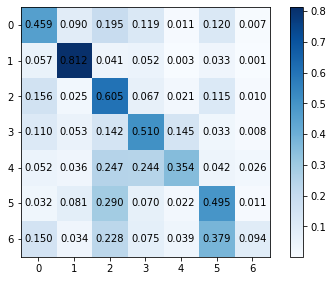

Normalized by prediction


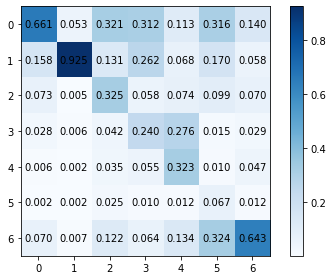

Epoch 5/5
4375/4375 [==============================] - 516s 118ms/step - loss: 1.3011 - val_loss: 1.0197
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.0043
 — val_f1: 0.43439 — val_precision: 0.45365 — val_recall: 0.50481 — 
              precision    recall  f1-score   support

     neutral      0.695     0.413     0.518      3597
       happy      0.897     0.838     0.867      6929
         sad      0.538     0.281     0.369      1172
    surprise      0.178     0.672     0.281       643
        fear      0.219     0.416     0.287       308
     disgust      0.123     0.371     0.184       186
       angry      0.526     0.543     0.534      1165

    accuracy                          0.634     14000
   macro avg      0.454     0.505     0.434     14000
weighted avg      0.726     0.634     0.659     14000

Non-normalized


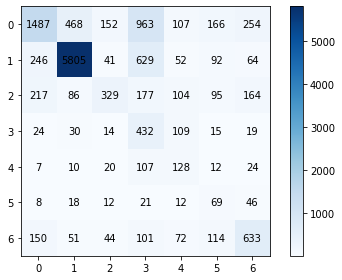

Normalized by true


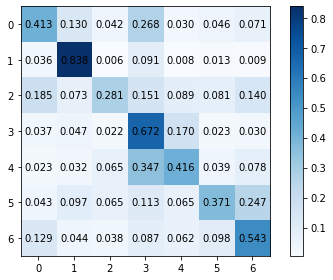

Normalized by prediction


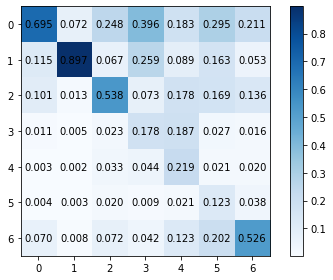

Num of layers: 2
Layer of size: 1228 with dropout rate of 0.53036567156181.
Layer of size: 609 with dropout rate of 0.572299508113075.
With a learning rate of 0.0006111252255775765.
With 24 layers unfrozen.
And a batch size of 4.
---
Epoch 1/5
17500/17500 [==============================] - 803s 46ms/step - loss: 2.0798 - val_loss: 2.0108


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 2.0114
 — val_f1: 0.00659 — val_precision: 0.02695 — val_recall: 0.14308 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.000     0.000     0.000      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.167     0.002     0.003       643
        fear      0.022     1.000     0.043       308
     disgust      0.000     0.000     0.000       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.022     14000
   macro avg      0.027     0.143     0.007     14000
weighted avg      0.008     0.022     0.001     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


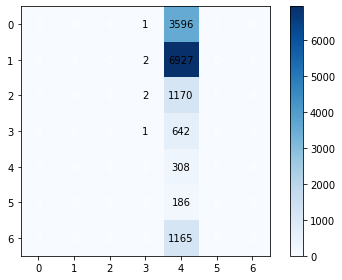

Normalized by true


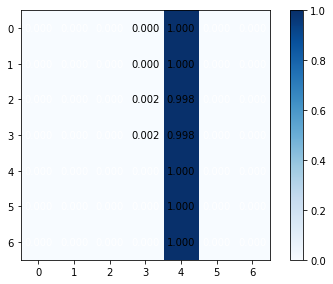

Normalized by prediction


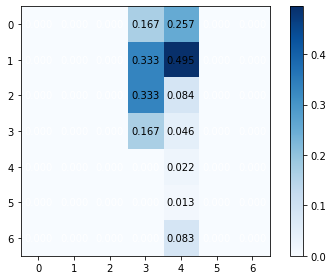

Epoch 2/5
17500/17500 [==============================] - 791s 45ms/step - loss: 1.9624 - val_loss: 1.9598
Calculating training loss
      1/Unknown - 0s 166ms/step - loss: 1.9627

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.9601
 — val_f1: 0.00615 — val_precision: 0.00314 — val_recall: 0.14286 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.000     0.000     0.000      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.000     0.000     0.000       643
        fear      0.022     1.000     0.043       308
     disgust      0.000     0.000     0.000       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.022     14000
   macro avg      0.003     0.143     0.006     14000
weighted avg      0.000     0.022     0.001     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


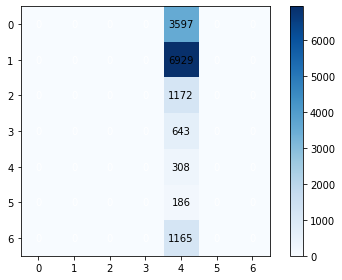

Normalized by true


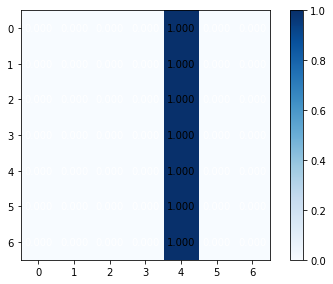

Normalized by prediction


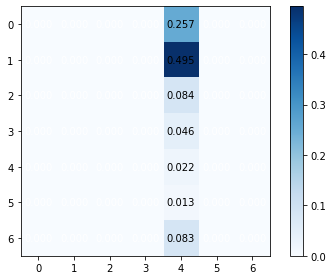

Epoch 3/5
17500/17500 [==============================] - 790s 45ms/step - loss: 1.9620 - val_loss: 1.9654
Calculating training loss
      1/Unknown - 0s 171ms/step - loss: 1.9643

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.9656
 — val_f1: 0.00615 — val_precision: 0.00314 — val_recall: 0.14286 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.000     0.000     0.000      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.000     0.000     0.000       643
        fear      0.022     1.000     0.043       308
     disgust      0.000     0.000     0.000       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.022     14000
   macro avg      0.003     0.143     0.006     14000
weighted avg      0.000     0.022     0.001     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


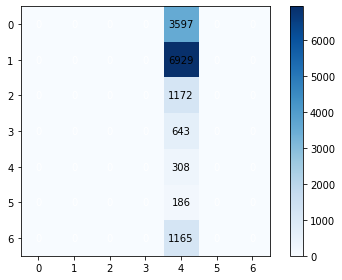

Normalized by true


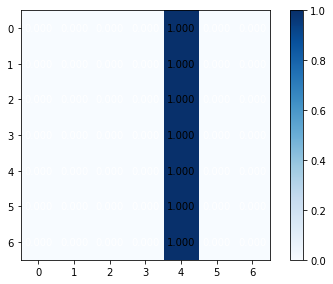

Normalized by prediction


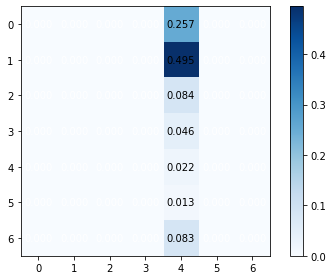

Epoch 4/5
17500/17500 [==============================] - 790s 45ms/step - loss: 1.9601 - val_loss: 1.9605
Calculating training loss
      1/Unknown - 0s 169ms/step - loss: 1.9599

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.9607
 — val_f1: 0.00615 — val_precision: 0.00314 — val_recall: 0.14286 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.000     0.000     0.000      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.000     0.000     0.000       643
        fear      0.022     1.000     0.043       308
     disgust      0.000     0.000     0.000       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.022     14000
   macro avg      0.003     0.143     0.006     14000
weighted avg      0.000     0.022     0.001     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


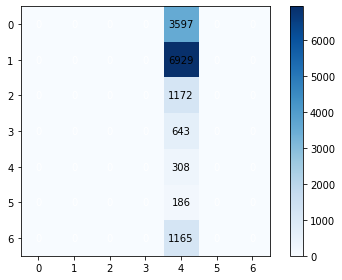

Normalized by true


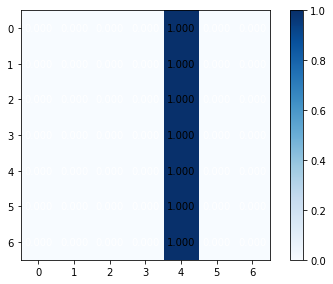

Normalized by prediction


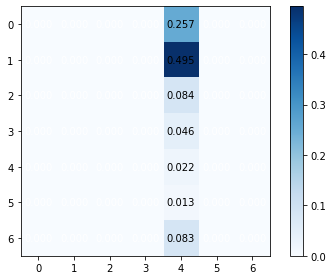

Epoch 5/5
17500/17500 [==============================] - 790s 45ms/step - loss: 1.9607 - val_loss: 1.9587
Calculating training loss
      1/Unknown - 0s 169ms/step - loss: 1.9562

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.9589
 — val_f1: 0.00615 — val_precision: 0.00314 — val_recall: 0.14286 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.000     0.000     0.000      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.000     0.000     0.000       643
        fear      0.022     1.000     0.043       308
     disgust      0.000     0.000     0.000       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.022     14000
   macro avg      0.003     0.143     0.006     14000
weighted avg      0.000     0.022     0.001     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


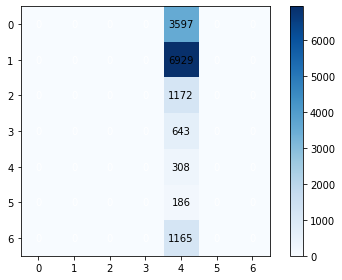

Normalized by true


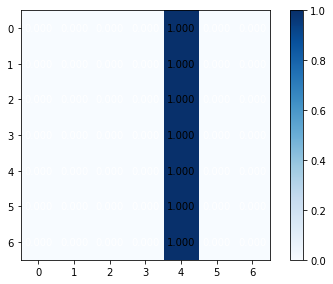

Normalized by prediction


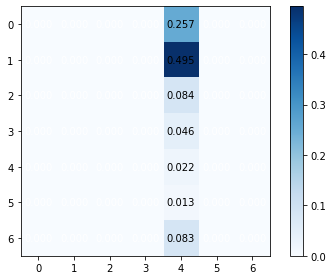

Num of layers: 1
Layer of size: 709 with dropout rate of 0.29729112658315826.
With a learning rate of 0.000267381585560793.
With 10 layers unfrozen.
And a batch size of 8.
---
Epoch 1/5
8750/8750 [==============================] - 612s 69ms/step - loss: 1.6840 - val_loss: 1.2533
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.2500
 — val_f1: 0.37838 — val_precision: 0.42686 — val_recall: 0.45167 — 
              precision    recall  f1-score   support

     neutral      0.626     0.392     0.482      3597
       happy      0.960     0.699     0.809      6929
         sad      0.325     0.456     0.380      1172
    surprise      0.359     0.337     0.348       643
        fear      0.302     0.328     0.315       308
     disgust      0.040     0.774     0.077       186
       angry      0.376     0.175     0.239      1165

    accuracy                          0.532     14000
   macro avg      0.427     0.452     0.378     14000
weighted 

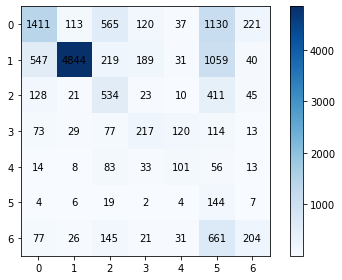

Normalized by true


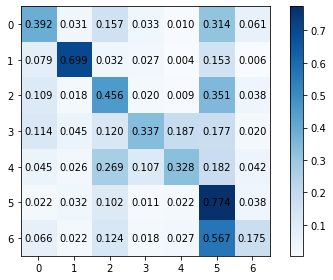

Normalized by prediction


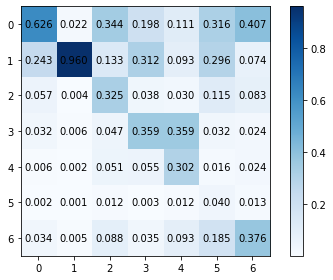

Epoch 2/5
8750/8750 [==============================] - 603s 69ms/step - loss: 1.3724 - val_loss: 0.9749
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 0.9732
 — val_f1: 0.45814 — val_precision: 0.45917 — val_recall: 0.52450 — 
              precision    recall  f1-score   support

     neutral      0.705     0.520     0.598      3597
       happy      0.924     0.843     0.882      6929
         sad      0.409     0.519     0.457      1172
    surprise      0.318     0.432     0.366       643
        fear      0.282     0.409     0.334       308
     disgust      0.080     0.570     0.140       186
       angry      0.497     0.379     0.430      1165

    accuracy                          0.662     14000
   macro avg      0.459     0.525     0.458     14000
weighted avg      0.736     0.662     0.690     14000

Non-normalized


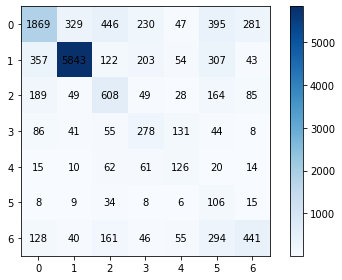

Normalized by true


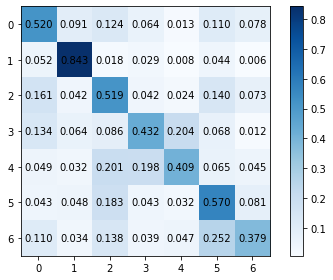

Normalized by prediction


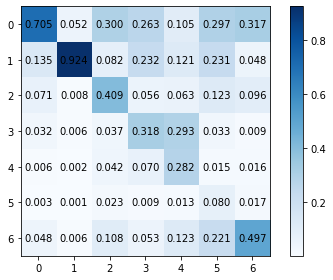

Epoch 3/5
8750/8750 [==============================] - 602s 69ms/step - loss: 1.2790 - val_loss: 1.0792
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0639
 — val_f1: 0.42843 — val_precision: 0.46487 — val_recall: 0.51257 — 
              precision    recall  f1-score   support

     neutral      0.697     0.507     0.587      3597
       happy      0.914     0.770     0.836      6929
         sad      0.418     0.470     0.443      1172
    surprise      0.317     0.521     0.394       643
        fear      0.295     0.393     0.337       308
     disgust      0.058     0.726     0.107       186
       angry      0.556     0.202     0.296      1165

    accuracy                          0.610     14000
   macro avg      0.465     0.513     0.428     14000
weighted avg      0.734     0.610     0.653     14000

Non-normalized


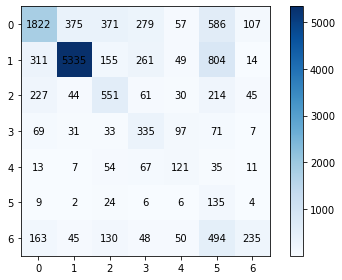

Normalized by true


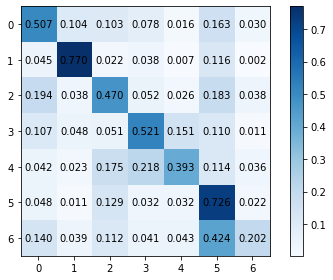

Normalized by prediction


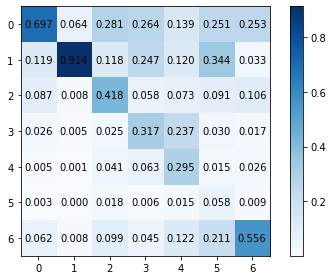

Epoch 4/5
8750/8750 [==============================] - 604s 69ms/step - loss: 1.2330 - val_loss: 0.9954
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 0.9784
 — val_f1: 0.44014 — val_precision: 0.45875 — val_recall: 0.52683 — 
              precision    recall  f1-score   support

     neutral      0.590     0.655     0.621      3597
       happy      0.968     0.723     0.828      6929
         sad      0.425     0.503     0.461      1172
    surprise      0.239     0.491     0.322       643
        fear      0.214     0.549     0.308       308
     disgust      0.107     0.516     0.178       186
       angry      0.667     0.250     0.364      1165

    accuracy                          0.631     14000
   macro avg      0.459     0.527     0.440     14000
weighted avg      0.739     0.631     0.662     14000

Non-normalized


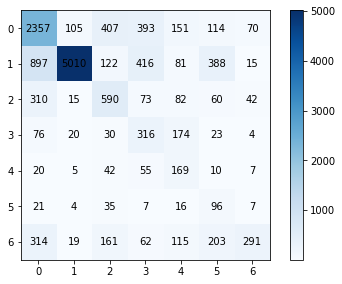

Normalized by true


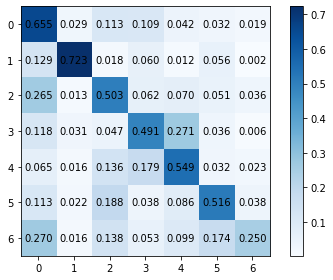

Normalized by prediction


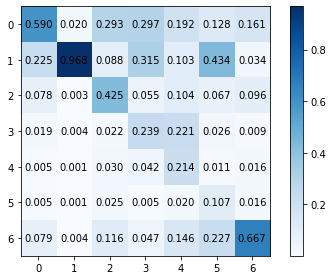

Epoch 5/5
8750/8750 [==============================] - 605s 69ms/step - loss: 1.1960 - val_loss: 0.8700
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 0.8489
 — val_f1: 0.47961 — val_precision: 0.48908 — val_recall: 0.55375 — 
              precision    recall  f1-score   support

     neutral      0.714     0.551     0.622      3597
       happy      0.903     0.863     0.882      6929
         sad      0.519     0.416     0.462      1172
    surprise      0.329     0.473     0.388       643
        fear      0.311     0.516     0.388       308
     disgust      0.087     0.667     0.154       186
       angry      0.560     0.391     0.461      1165

    accuracy                          0.678     14000
   macro avg      0.489     0.554     0.480     14000
weighted avg      0.744     0.678     0.702     14000

Non-normalized


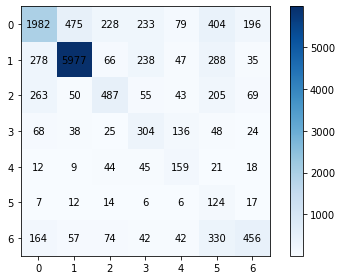

Normalized by true


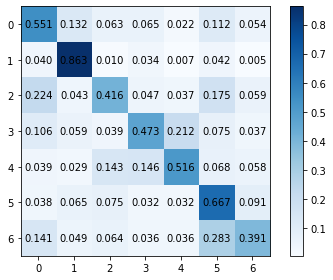

Normalized by prediction


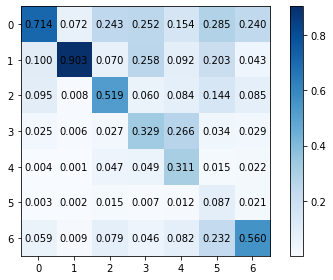

Num of layers: 3
Layer of size: 1548 with dropout rate of 0.45754159616212353.
Layer of size: 1273 with dropout rate of 0.4638803892610746.
Layer of size: 467 with dropout rate of 0.6097504339996093.
With a learning rate of 0.00041923304900988554.
With 17 layers unfrozen.
And a batch size of 4.
---
Epoch 1/5
17500/17500 [==============================] - 810s 46ms/step - loss: 2.0198 - val_loss: 1.9025
Calculating training loss
      1/Unknown - 0s 171ms/step - loss: 1.8927

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.8988
 — val_f1: 0.03951 — val_precision: 0.08662 — val_recall: 0.18290 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.352     0.005     0.011      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.000     0.000     0.000       643
        fear      0.156     0.321     0.210       308
     disgust      0.013     0.935     0.026       186
       angry      0.085     0.018     0.030      1165

    accuracy                          0.024     14000
   macro avg      0.087     0.183     0.040     14000
weighted avg      0.185     0.024     0.013     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


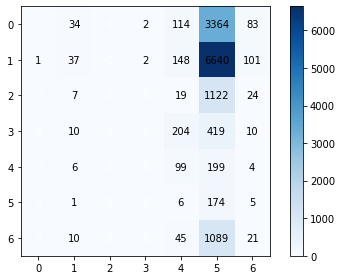

Normalized by true


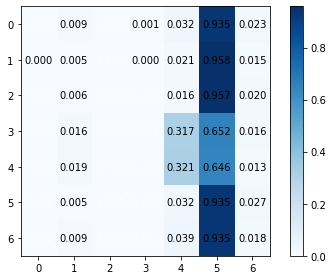

Normalized by prediction


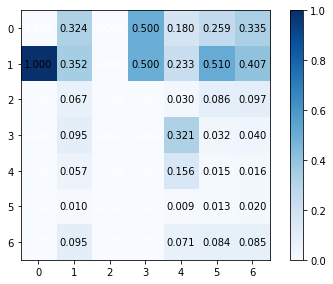

Epoch 2/5
17500/17500 [==============================] - 802s 46ms/step - loss: 1.9179 - val_loss: 1.8544
Calculating training loss
      1/Unknown - 0s 172ms/step - loss: 1.8464

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.8479
 — val_f1: 0.11047 — val_precision: 0.10736 — val_recall: 0.24198 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.653     0.547     0.595      6929
         sad      0.000     0.000     0.000      1172
    surprise      0.000     0.000     0.000       643
        fear      0.083     0.669     0.148       308
     disgust      0.016     0.478     0.030       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.292     14000
   macro avg      0.107     0.242     0.110     14000
weighted avg      0.325     0.292     0.298     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


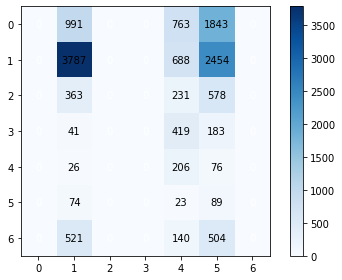

Normalized by true


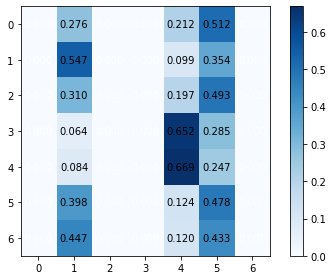

Normalized by prediction


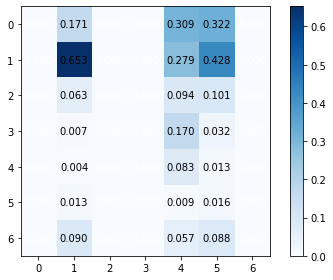

Epoch 3/5
17500/17500 [==============================] - 801s 46ms/step - loss: 1.8634 - val_loss: 1.7889
Calculating training loss
      1/Unknown - 0s 172ms/step - loss: 1.8051

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.7861
 — val_f1: 0.12672 — val_precision: 0.22587 — val_recall: 0.24407 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.996     0.137     0.241      6929
         sad      0.114     0.142     0.127      1172
    surprise      0.394     0.387     0.391       643
        fear      0.062     0.240     0.098       308
     disgust      0.015     0.801     0.030       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.114     14000
   macro avg      0.226     0.244     0.127     14000
weighted avg      0.522     0.114     0.151     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


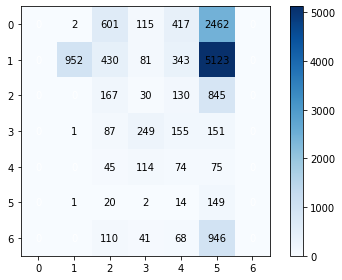

Normalized by true


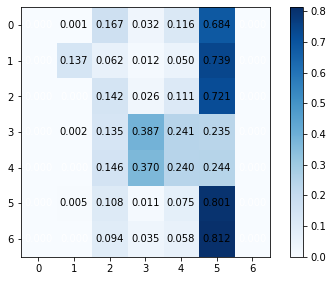

Normalized by prediction


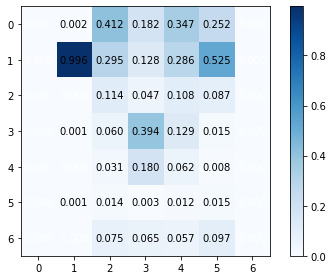

Epoch 4/5
17500/17500 [==============================] - 801s 46ms/step - loss: 1.8232 - val_loss: 1.5684
Calculating training loss
      1/Unknown - 0s 169ms/step - loss: 1.5708

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 75ms/step - loss: 1.5697
 — val_f1: 0.15705 — val_precision: 0.22313 — val_recall: 0.28872 — 
              precision    recall  f1-score   support

     neutral      0.402     0.089     0.146      3597
       happy      0.821     0.621     0.707      6929
         sad      0.200     0.003     0.007      1172
    surprise      0.000     0.000     0.000       643
        fear      0.119     0.646     0.201       308
     disgust      0.020     0.661     0.038       186
       angry      0.000     0.000     0.000      1165

    accuracy                          0.354     14000
   macro avg      0.223     0.289     0.157     14000
weighted avg      0.529     0.354     0.393     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


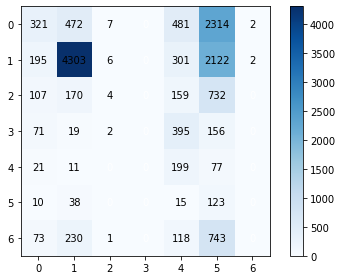

Normalized by true


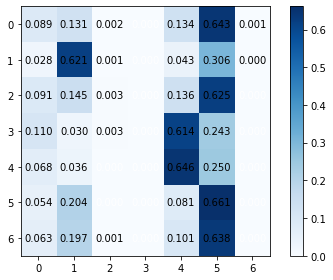

Normalized by prediction


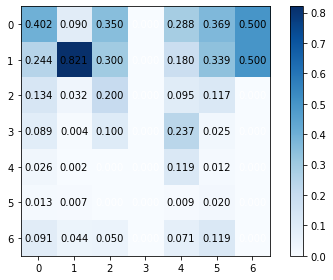

Epoch 5/5
17500/17500 [==============================] - 801s 46ms/step - loss: 1.8123 - val_loss: 1.3842
Calculating training loss
      1/Unknown - 0s 172ms/step - loss: 1.3709

/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1094/1094 [==============================] - 82s 74ms/step - loss: 1.3916
 — val_f1: 0.17448 — val_precision: 0.14981 — val_recall: 0.22899 — 
              precision    recall  f1-score   support

     neutral      0.000     0.000     0.000      3597
       happy      0.601     0.931     0.731      6929
         sad      0.139     0.142     0.140      1172
    surprise      0.000     0.000     0.000       643
        fear      0.190     0.445     0.266       308
     disgust      0.008     0.032     0.012       186
       angry      0.111     0.053     0.072      1165

    accuracy                          0.487     14000
   macro avg      0.150     0.229     0.174     14000
weighted avg      0.323     0.487     0.385     14000

Non-normalized


/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/luay/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


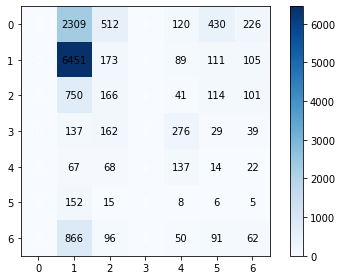

Normalized by true


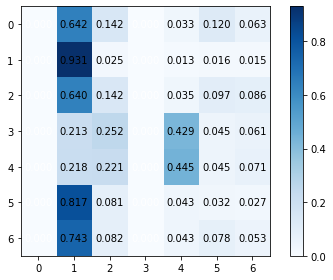

Normalized by prediction


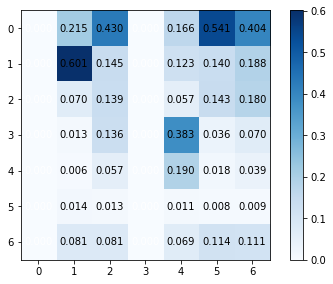

Num of layers: 3
Layer of size: 191 with dropout rate of 0.3121303100401413.
Layer of size: 1733 with dropout rate of 0.2536383241070854.
Layer of size: 1438 with dropout rate of 0.3612662361765083.
With a learning rate of 8.21607421028468e-05.
With 26 layers unfrozen.
And a batch size of 8.
---
Epoch 1/5
8750/8750 [==============================] - 611s 69ms/step - loss: 1.7169 - val_loss: 1.1450
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1388
 — val_f1: 0.38632 — val_precision: 0.41739 — val_recall: 0.47328 — 
              precision    recall  f1-score   support

     neutral      0.667     0.467     0.549      3597
       happy      0.913     0.798     0.851      6929
         sad      0.351     0.491     0.409      1172
    surprise      0.247     0.351     0.290       643
        fear      0.215     0.484     0.298       308
     disgust      0.059     0.597     0.108       186
       angry      0.469     0.125     0.198      11

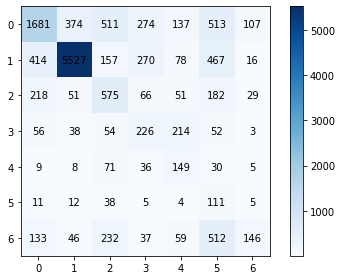

Normalized by true


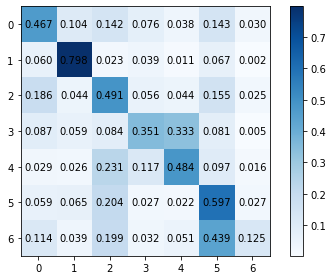

Normalized by prediction


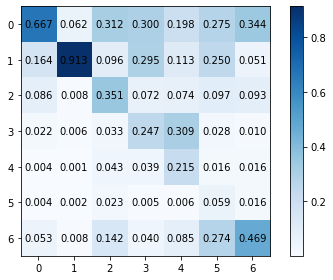

Epoch 2/5
8750/8750 [==============================] - 603s 69ms/step - loss: 1.3732 - val_loss: 1.1627
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1463
 — val_f1: 0.43238 — val_precision: 0.45024 — val_recall: 0.52883 — 
              precision    recall  f1-score   support

     neutral      0.671     0.519     0.585      3597
       happy      0.948     0.711     0.812      6929
         sad      0.405     0.435     0.419      1172
    surprise      0.269     0.543     0.360       643
        fear      0.268     0.484     0.345       308
     disgust      0.058     0.694     0.107       186
       angry      0.532     0.317     0.397      1165

    accuracy                          0.593     14000
   macro avg      0.450     0.529     0.432     14000
weighted avg      0.739     0.593     0.646     14000

Non-normalized


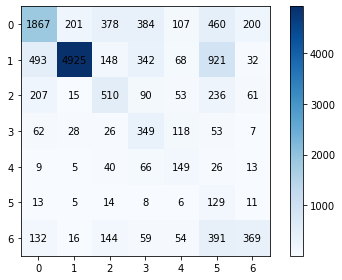

Normalized by true


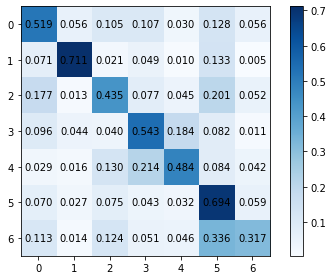

Normalized by prediction


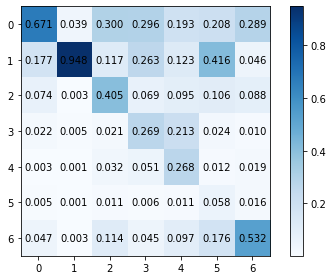

Epoch 3/5
8750/8750 [==============================] - 604s 69ms/step - loss: 1.2607 - val_loss: 0.9816
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 0.9564
 — val_f1: 0.46605 — val_precision: 0.45864 — val_recall: 0.54996 — 
              precision    recall  f1-score   support

     neutral      0.642     0.567     0.602      3597
       happy      0.964     0.759     0.849      6929
         sad      0.439     0.530     0.480      1172
    surprise      0.217     0.605     0.319       643
        fear      0.304     0.468     0.369       308
     disgust      0.120     0.532     0.196       186
       angry      0.524     0.390     0.447      1165

    accuracy                          0.643     14000
   macro avg      0.459     0.550     0.466     14000
weighted avg      0.741     0.643     0.678     14000

Non-normalized


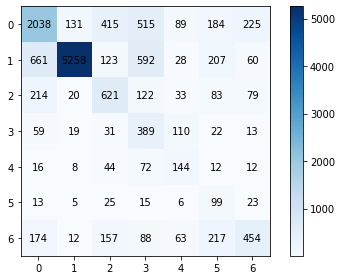

Normalized by true


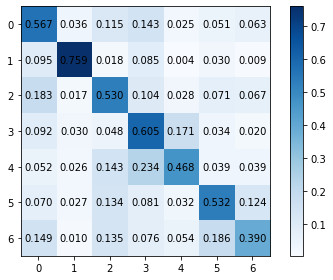

Normalized by prediction


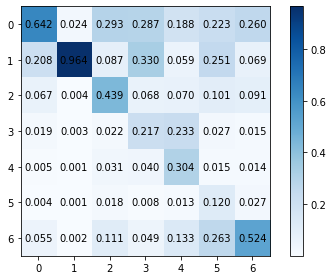

Epoch 4/5
8750/8750 [==============================] - 602s 69ms/step - loss: 1.1983 - val_loss: 1.0988
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0708
 — val_f1: 0.42985 — val_precision: 0.43138 — val_recall: 0.55342 — 
              precision    recall  f1-score   support

     neutral      0.644     0.425     0.512      3597
       happy      0.975     0.704     0.818      6929
         sad      0.395     0.530     0.453      1172
    surprise      0.198     0.624     0.300       643
        fear      0.237     0.516     0.324       308
     disgust      0.091     0.667     0.160       186
       angry      0.480     0.409     0.442      1165

    accuracy                          0.585     14000
   macro avg      0.431     0.553     0.430     14000
weighted avg      0.737     0.585     0.634     14000

Non-normalized


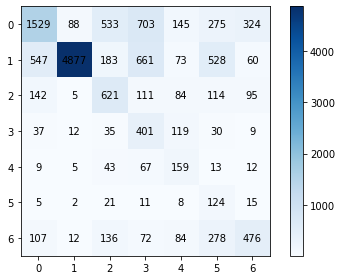

Normalized by true


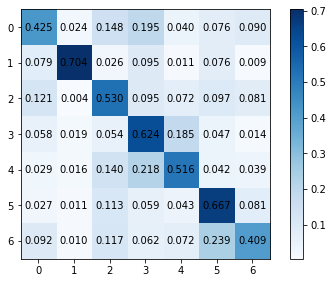

Normalized by prediction


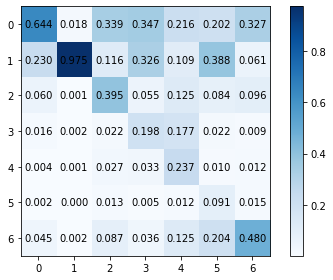

Epoch 5/5
8750/8750 [==============================] - 603s 69ms/step - loss: 1.1522 - val_loss: 1.0818
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0451
 — val_f1: 0.42724 — val_precision: 0.44290 — val_recall: 0.53871 — 
              precision    recall  f1-score   support

     neutral      0.683     0.437     0.533      3597
       happy      0.954     0.731     0.828      6929
         sad      0.442     0.437     0.439      1172
    surprise      0.260     0.518     0.347       643
        fear      0.225     0.529     0.316       308
     disgust      0.060     0.747     0.111       186
       angry      0.476     0.372     0.417      1165

    accuracy                          0.587     14000
   macro avg      0.443     0.539     0.427     14000
weighted avg      0.742     0.587     0.643     14000

Non-normalized


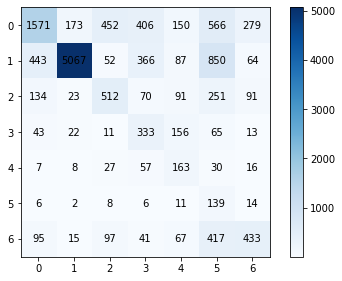

Normalized by true


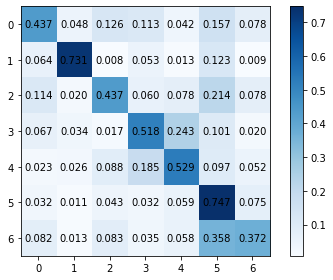

Normalized by prediction


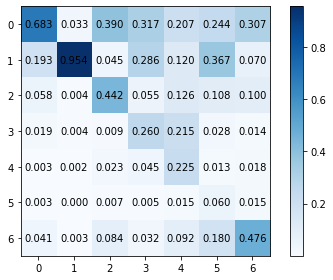

Num of layers: 3
Layer of size: 1035 with dropout rate of 0.36512303808034613.
Layer of size: 1136 with dropout rate of 0.09981954129837638.
Layer of size: 1703 with dropout rate of 0.21158452831113927.
With a learning rate of 0.00041119265776886114.
With 16 layers unfrozen.
And a batch size of 4.
---
Epoch 1/5
17500/17500 [==============================] - 819s 46ms/step - loss: 1.9765 - val_loss: 1.8252
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.8223
 — val_f1: 0.06257 — val_precision: 0.18205 — val_recall: 0.20410 — 
              precision    recall  f1-score   support

     neutral      0.300     0.002     0.003      3597
       happy      0.557     0.005     0.010      6929
         sad      0.065     0.021     0.032      1172
    surprise      0.111     0.002     0.003       643
        fear      0.132     0.455     0.205       308
     disgust      0.021     0.032     0.026       186
       angry      0.087     0.912     0.159

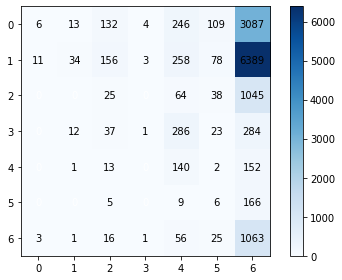

Normalized by true


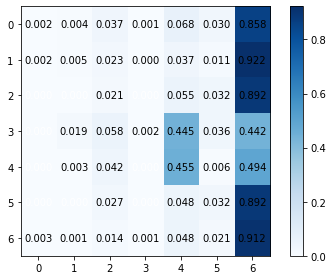

Normalized by prediction


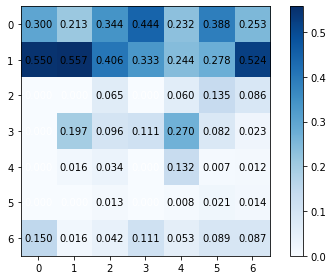

Epoch 2/5
17500/17500 [==============================] - 812s 46ms/step - loss: 1.8440 - val_loss: 1.2406
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.2486
 — val_f1: 0.26157 — val_precision: 0.31008 — val_recall: 0.29488 — 
              precision    recall  f1-score   support

     neutral      0.530     0.165     0.252      3597
       happy      0.690     0.918     0.788      6929
         sad      0.204     0.019     0.034      1172
    surprise      0.316     0.171     0.222       643
        fear      0.144     0.321     0.199       308
     disgust      0.024     0.134     0.041       186
       angry      0.263     0.335     0.294      1165

    accuracy                          0.543     14000
   macro avg      0.310     0.295     0.262     14000
weighted avg      0.534     0.543     0.497     14000

Non-normalized


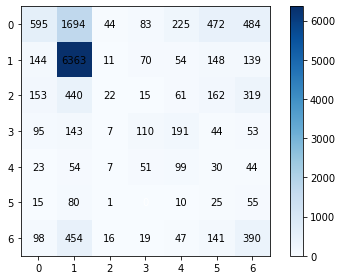

Normalized by true


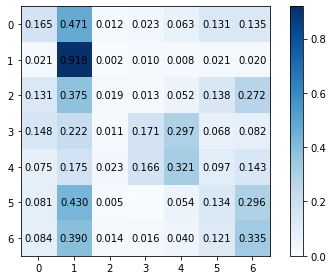

Normalized by prediction


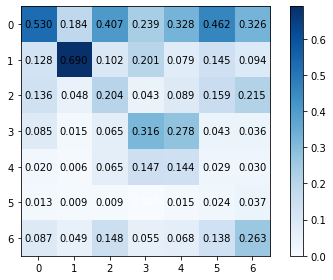

Epoch 3/5
17500/17500 [==============================] - 810s 46ms/step - loss: 1.7071 - val_loss: 1.3101
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.3243
 — val_f1: 0.27660 — val_precision: 0.34419 — val_recall: 0.35194 — 
              precision    recall  f1-score   support

     neutral      0.556     0.240     0.335      3597
       happy      0.903     0.803     0.850      6929
         sad      0.333     0.008     0.015      1172
    surprise      0.194     0.064     0.096       643
        fear      0.180     0.513     0.267       308
     disgust      0.010     0.075     0.018       186
       angry      0.231     0.761     0.355      1165

    accuracy                          0.538     14000
   macro avg      0.344     0.352     0.277     14000
weighted avg      0.650     0.538     0.548     14000

Non-normalized


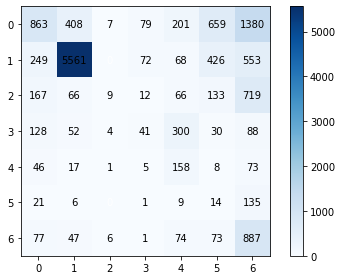

Normalized by true


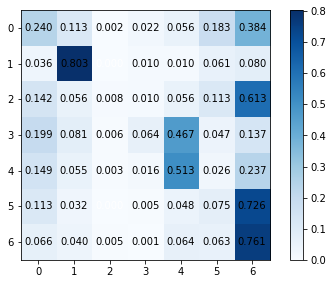

Normalized by prediction


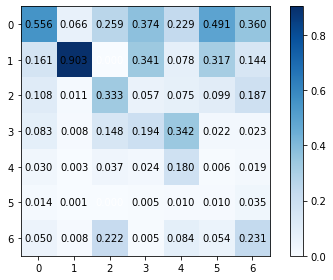

Epoch 4/5
17500/17500 [==============================] - 810s 46ms/step - loss: 1.6230 - val_loss: 1.2494
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.2548
 — val_f1: 0.30947 — val_precision: 0.36388 — val_recall: 0.37835 — 
              precision    recall  f1-score   support

     neutral      0.519     0.681     0.589      3597
       happy      0.920     0.801     0.856      6929
         sad      0.322     0.047     0.082      1172
    surprise      0.169     0.241     0.199       643
        fear      0.216     0.445     0.291       308
     disgust      0.053     0.403     0.093       186
       angry      0.350     0.031     0.057      1165

    accuracy                          0.604     14000
   macro avg      0.364     0.378     0.309     14000
weighted avg      0.658     0.604     0.603     14000

Non-normalized


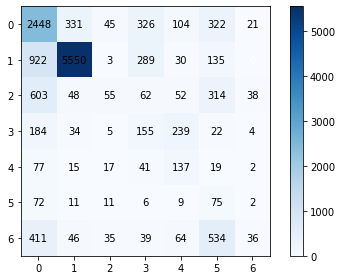

Normalized by true


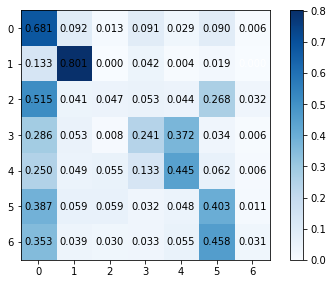

Normalized by prediction


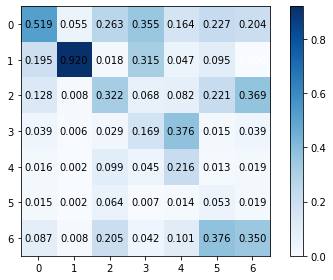

Epoch 5/5
17500/17500 [==============================] - 811s 46ms/step - loss: 1.5941 - val_loss: 1.0577
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.0672
 — val_f1: 0.30527 — val_precision: 0.40484 — val_recall: 0.38580 — 
              precision    recall  f1-score   support

     neutral      0.572     0.609     0.590      3597
       happy      0.850     0.878     0.863      6929
         sad      0.400     0.005     0.010      1172
    surprise      0.295     0.168     0.214       643
        fear      0.259     0.399     0.315       308
     disgust      0.055     0.618     0.101       186
       angry      0.403     0.023     0.044      1165

    accuracy                          0.618     14000
   macro avg      0.405     0.386     0.305     14000
weighted avg      0.654     0.618     0.601     14000

Non-normalized


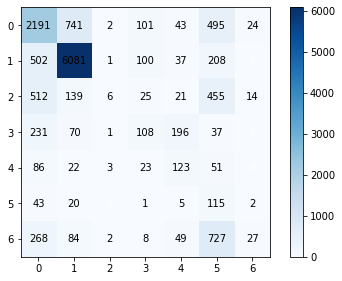

Normalized by true


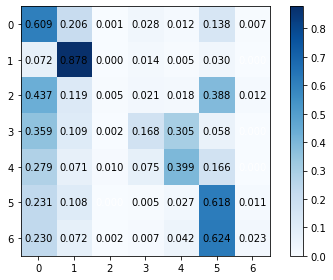

Normalized by prediction


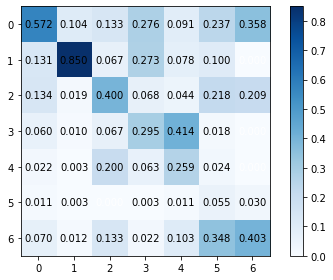

Num of layers: 2
Layer of size: 116 with dropout rate of 0.14487629269718075.
Layer of size: 1067 with dropout rate of 0.648012949159693.
With a learning rate of 2.24969804718011e-05.
With 30 layers unfrozen.
And a batch size of 32.
---
Epoch 1/5
2188/2188 [==============================] - 470s 212ms/step - loss: 1.9304 - val_loss: 1.5163
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.5209
 — val_f1: 0.26954 — val_precision: 0.28633 — val_recall: 0.34424 — 
              precision    recall  f1-score   support

     neutral      0.507     0.208     0.295      3597
       happy      0.829     0.681     0.748      6929
         sad      0.179     0.113     0.139      1172
    surprise      0.118     0.226     0.155       643
        fear      0.104     0.526     0.174       308
     disgust      0.039     0.145     0.061       186
       angry      0.228     0.511     0.315      1165

    accuracy                          0.466     14000
 

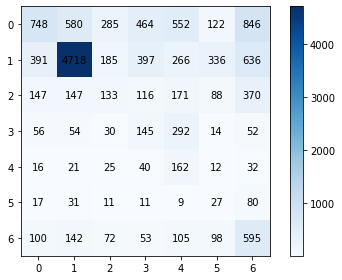

Normalized by true


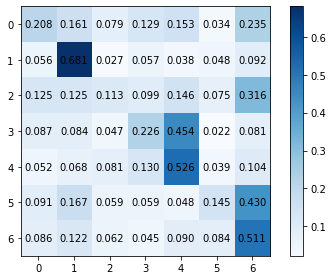

Normalized by prediction


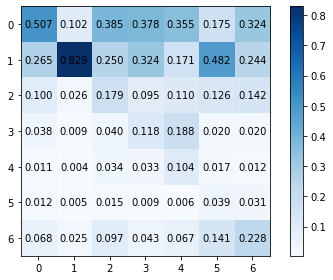

Epoch 2/5
2188/2188 [==============================] - 464s 212ms/step - loss: 1.6216 - val_loss: 1.2309
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.2300
 — val_f1: 0.37577 — val_precision: 0.36740 — val_recall: 0.45313 — 
              precision    recall  f1-score   support

     neutral      0.579     0.479     0.524      3597
       happy      0.939     0.722     0.817      6929
         sad      0.262     0.261     0.261      1172
    surprise      0.218     0.336     0.264       643
        fear      0.159     0.571     0.248       308
     disgust      0.075     0.339     0.123       186
       angry      0.341     0.464     0.393      1165

    accuracy                          0.574     14000
   macro avg      0.367     0.453     0.376     14000
weighted avg      0.678     0.574     0.613     14000

Non-normalized


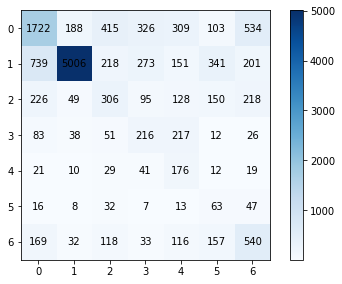

Normalized by true


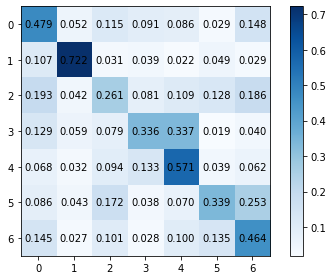

Normalized by prediction


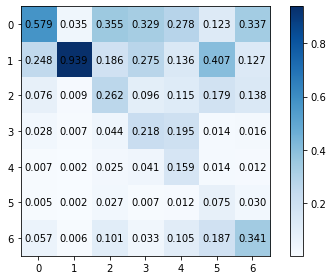

Epoch 3/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.4528 - val_loss: 1.1311
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1209
 — val_f1: 0.40514 — val_precision: 0.39280 — val_recall: 0.48455 — 
              precision    recall  f1-score   support

     neutral      0.592     0.528     0.558      3597
       happy      0.954     0.733     0.829      6929
         sad      0.321     0.337     0.329      1172
    surprise      0.235     0.386     0.292       643
        fear      0.181     0.552     0.273       308
     disgust      0.088     0.409     0.145       186
       angry      0.380     0.447     0.411      1165

    accuracy                          0.599     14000
   macro avg      0.393     0.485     0.405     14000
weighted avg      0.698     0.599     0.637     14000

Non-normalized


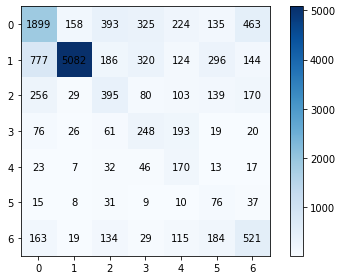

Normalized by true


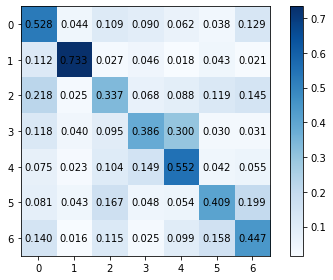

Normalized by prediction


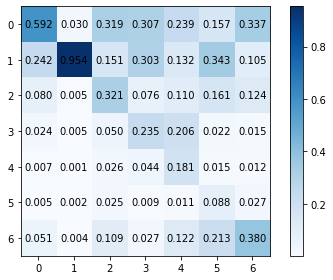

Epoch 4/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.3557 - val_loss: 1.1081
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0910
 — val_f1: 0.41659 — val_precision: 0.40542 — val_recall: 0.51386 — 
              precision    recall  f1-score   support

     neutral      0.620     0.492     0.548      3597
       happy      0.956     0.739     0.834      6929
         sad      0.376     0.366     0.371      1172
    surprise      0.217     0.418     0.286       643
        fear      0.182     0.581     0.277       308
     disgust      0.100     0.511     0.168       186
       angry      0.388     0.489     0.433      1165

    accuracy                          0.603     14000
   macro avg      0.405     0.514     0.417     14000
weighted avg      0.711     0.603     0.642     14000

Non-normalized


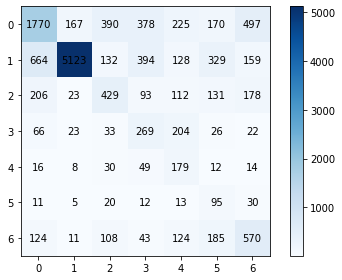

Normalized by true


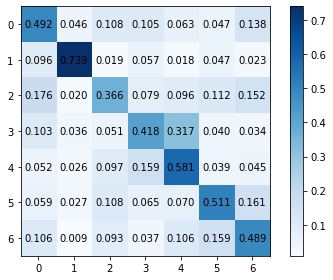

Normalized by prediction


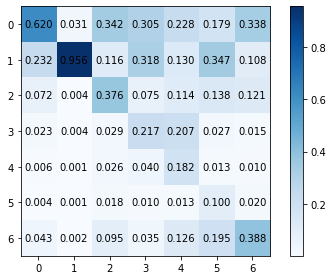

Epoch 5/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.2872 - val_loss: 1.1531
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.1292
 — val_f1: 0.41476 — val_precision: 0.40502 — val_recall: 0.52365 — 
              precision    recall  f1-score   support

     neutral      0.618     0.444     0.517      3597
       happy      0.966     0.709     0.818      6929
         sad      0.345     0.463     0.395      1172
    surprise      0.248     0.443     0.318       643
        fear      0.191     0.562     0.285       308
     disgust      0.084     0.570     0.147       186
       angry      0.384     0.475     0.424      1165

    accuracy                          0.584     14000
   macro avg      0.405     0.524     0.415     14000
weighted avg      0.714     0.584     0.629     14000

Non-normalized


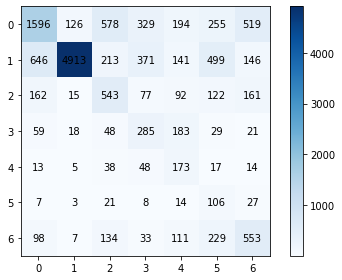

Normalized by true


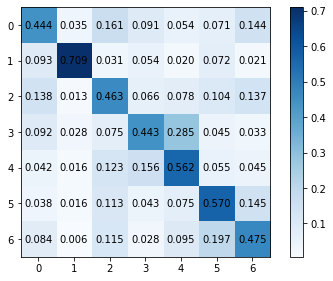

Normalized by prediction


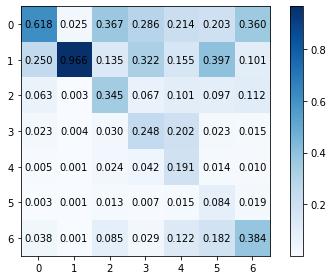

Num of layers: 3
Layer of size: 295 with dropout rate of 0.23069994880790834.
Layer of size: 235 with dropout rate of 0.25315543483962427.
Layer of size: 1385 with dropout rate of 0.36827770087659856.
With a learning rate of 7.070659365287942e-05.
With 26 layers unfrozen.
And a batch size of 16.
---
Epoch 1/5
4375/4375 [==============================] - 522s 118ms/step - loss: 1.7431 - val_loss: 1.0335
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0293
 — val_f1: 0.41419 — val_precision: 0.41816 — val_recall: 0.49404 — 
              precision    recall  f1-score   support

     neutral      0.666     0.489     0.564      3597
       happy      0.927     0.811     0.865      6929
         sad      0.333     0.453     0.384      1172
    surprise      0.236     0.373     0.290       643
        fear      0.217     0.481     0.299       308
     disgust      0.082     0.565     0.143       186
       angry      0.466     0.287     0.355   

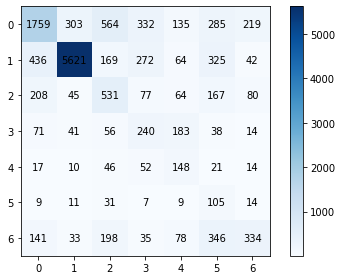

Normalized by true


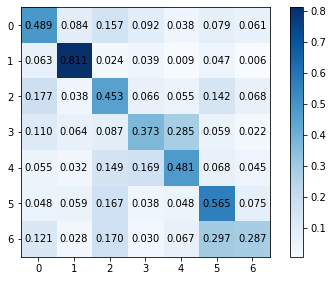

Normalized by prediction


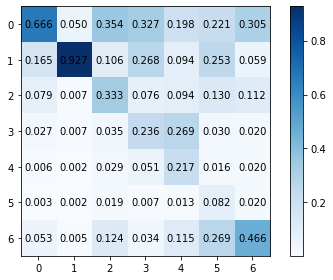

Epoch 2/5
4375/4375 [==============================] - 515s 118ms/step - loss: 1.3694 - val_loss: 1.0156
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 0.9969
 — val_f1: 0.45519 — val_precision: 0.44447 — val_recall: 0.53753 — 
              precision    recall  f1-score   support

     neutral      0.670     0.558     0.609      3597
       happy      0.947     0.768     0.848      6929
         sad      0.469     0.397     0.430      1172
    surprise      0.294     0.468     0.361       643
        fear      0.250     0.471     0.326       308
     disgust      0.089     0.548     0.153       186
       angry      0.393     0.553     0.460      1165

    accuracy                          0.642     14000
   macro avg      0.444     0.538     0.455     14000
weighted avg      0.733     0.642     0.676     14000

Non-normalized


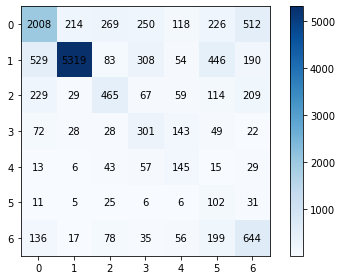

Normalized by true


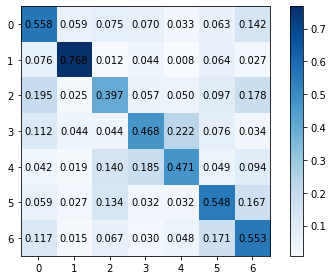

Normalized by prediction


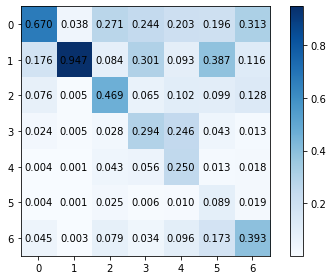

Epoch 3/5
4375/4375 [==============================] - 516s 118ms/step - loss: 1.2408 - val_loss: 1.0496
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.0159
 — val_f1: 0.44739 — val_precision: 0.43845 — val_recall: 0.53799 — 
              precision    recall  f1-score   support

     neutral      0.652     0.522     0.580      3597
       happy      0.961     0.704     0.813      6929
         sad      0.403     0.537     0.460      1172
    surprise      0.289     0.485     0.363       643
        fear      0.263     0.464     0.336       308
     disgust      0.068     0.565     0.121       186
       angry      0.432     0.489     0.459      1165

    accuracy                          0.608     14000
   macro avg      0.438     0.538     0.447     14000
weighted avg      0.733     0.608     0.654     14000

Non-normalized


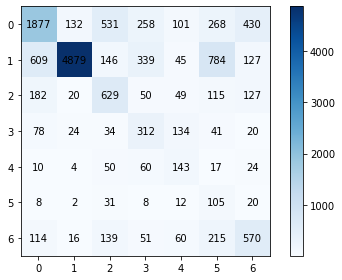

Normalized by true


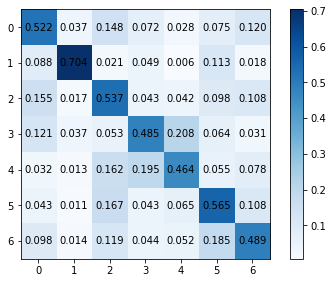

Normalized by prediction


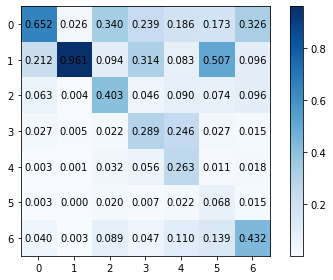

Epoch 4/5
4375/4375 [==============================] - 515s 118ms/step - loss: 1.1675 - val_loss: 1.1310
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0944
 — val_f1: 0.42406 — val_precision: 0.42302 — val_recall: 0.55115 — 
              precision    recall  f1-score   support

     neutral      0.644     0.399     0.493      3597
       happy      0.972     0.691     0.808      6929
         sad      0.386     0.551     0.454      1172
    surprise      0.213     0.565     0.309       643
        fear      0.198     0.558     0.292       308
     disgust      0.081     0.624     0.144       186
       angry      0.467     0.470     0.469      1165

    accuracy                          0.576     14000
   macro avg      0.423     0.551     0.424     14000
weighted avg      0.733     0.576     0.626     14000

Non-normalized


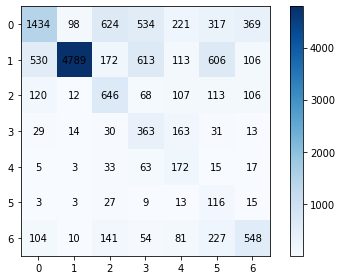

Normalized by true


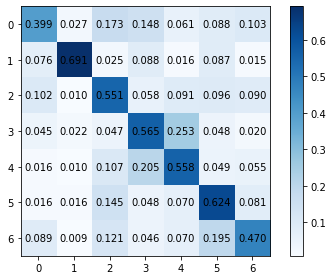

Normalized by prediction


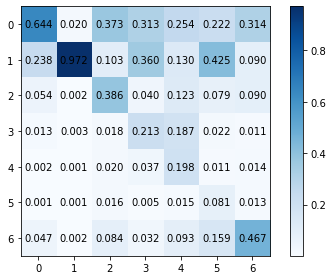

Epoch 5/5
4375/4375 [==============================] - 516s 118ms/step - loss: 1.1075 - val_loss: 0.9713
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 0.9180
 — val_f1: 0.46916 — val_precision: 0.44604 — val_recall: 0.57041 — 
              precision    recall  f1-score   support

     neutral      0.662     0.495     0.566      3597
       happy      0.964     0.770     0.856      6929
         sad      0.418     0.525     0.465      1172
    surprise      0.260     0.551     0.353       643
        fear      0.230     0.555     0.325       308
     disgust      0.132     0.527     0.211       186
       angry      0.457     0.571     0.508      1165

    accuracy                          0.644     14000
   macro avg      0.446     0.570     0.469     14000
weighted avg      0.739     0.644     0.677     14000

Non-normalized


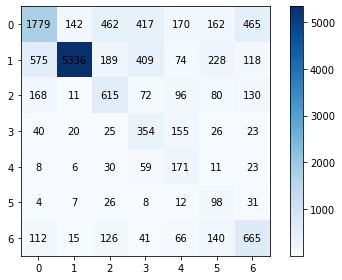

Normalized by true


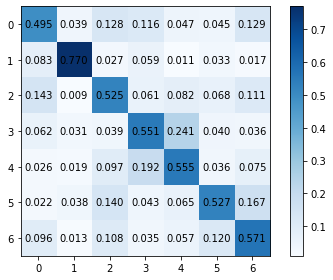

Normalized by prediction


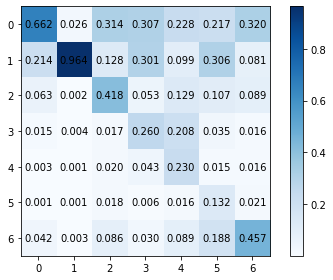

Num of layers: 3
Layer of size: 1652 with dropout rate of 0.6275476622565291.
Layer of size: 758 with dropout rate of 0.5500112358001314.
Layer of size: 1597 with dropout rate of 0.19838515934466125.
With a learning rate of 0.0005805196187061559.
With 21 layers unfrozen.
And a batch size of 32.
---
Epoch 1/5
2188/2188 [==============================] - 471s 212ms/step - loss: 1.7924 - val_loss: 1.4735
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.4727
 — val_f1: 0.31858 — val_precision: 0.37101 — val_recall: 0.38656 — 
              precision    recall  f1-score   support

     neutral      0.482     0.718     0.577      3597
       happy      0.936     0.573     0.711      6929
         sad      0.311     0.206     0.248      1172
    surprise      0.151     0.190     0.168       643
        fear      0.118     0.646     0.199       308
     disgust      0.051     0.215     0.082       186
       angry      0.548     0.157     0.244    

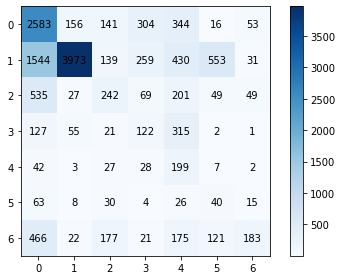

Normalized by true


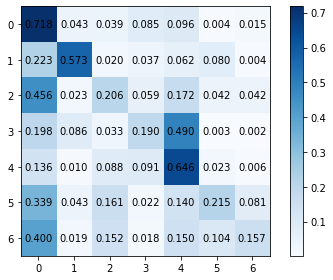

Normalized by prediction


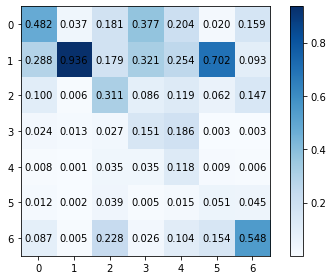

Epoch 2/5
2188/2188 [==============================] - 464s 212ms/step - loss: 1.5019 - val_loss: 1.1828
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1877
 — val_f1: 0.37650 — val_precision: 0.41558 — val_recall: 0.44469 — 
              precision    recall  f1-score   support

     neutral      0.632     0.490     0.552      3597
       happy      0.900     0.808     0.852      6929
         sad      0.413     0.195     0.265      1172
    surprise      0.248     0.551     0.342       643
        fear      0.094     0.234     0.134       308
     disgust      0.062     0.548     0.111       186
       angry      0.560     0.287     0.379      1165

    accuracy                          0.604     14000
   macro avg      0.416     0.445     0.376     14000
weighted avg      0.703     0.604     0.637     14000

Non-normalized


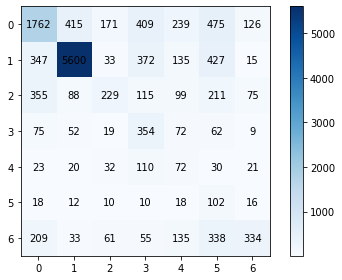

Normalized by true


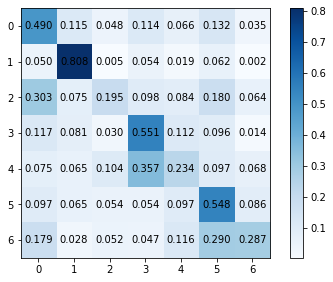

Normalized by prediction


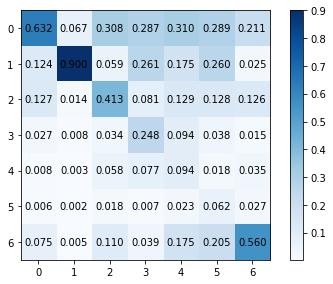

Epoch 3/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.4365 - val_loss: 1.2551
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.2524
 — val_f1: 0.36066 — val_precision: 0.43300 — val_recall: 0.46473 — 
              precision    recall  f1-score   support

     neutral      0.596     0.500     0.543      3597
       happy      0.973     0.666     0.790      6929
         sad      0.457     0.321     0.377      1172
    surprise      0.080     0.288     0.125       643
        fear      0.127     0.828     0.220       308
     disgust      0.110     0.468     0.179       186
       angry      0.688     0.184     0.290      1165

    accuracy                          0.538     14000
   macro avg      0.433     0.465     0.361     14000
weighted avg      0.738     0.538     0.599     14000

Non-normalized


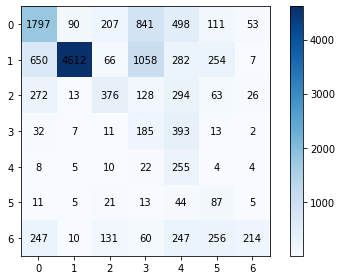

Normalized by true


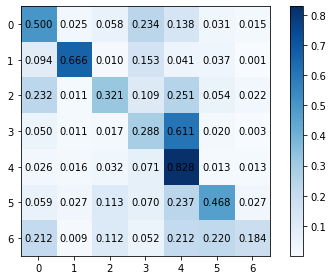

Normalized by prediction


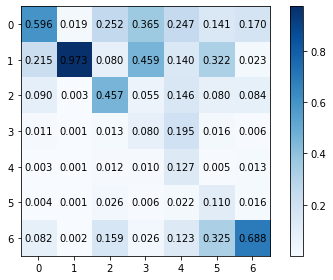

Epoch 4/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.3732 - val_loss: 1.3254
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.3231
 — val_f1: 0.36423 — val_precision: 0.45157 — val_recall: 0.47269 — 
              precision    recall  f1-score   support

     neutral      0.623     0.408     0.493      3597
       happy      0.960     0.556     0.704      6929
         sad      0.337     0.553     0.419      1172
    surprise      0.307     0.479     0.374       643
        fear      0.221     0.464     0.299       308
     disgust      0.035     0.737     0.068       186
       angry      0.677     0.112     0.192      1165

    accuracy                          0.478     14000
   macro avg      0.452     0.473     0.364     14000
weighted avg      0.739     0.478     0.551     14000

Non-normalized


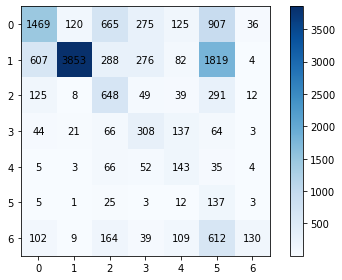

Normalized by true


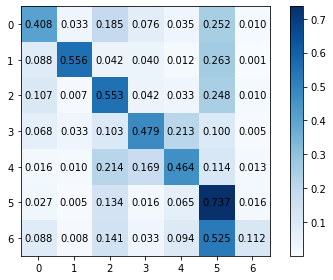

Normalized by prediction


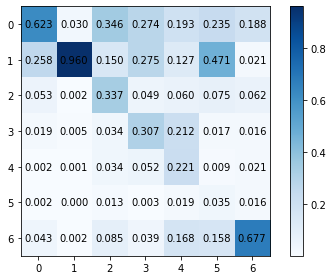

Epoch 5/5
2188/2188 [==============================] - 464s 212ms/step - loss: 1.3681 - val_loss: 1.2500
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.2463
 — val_f1: 0.36760 — val_precision: 0.43626 — val_recall: 0.48589 — 
              precision    recall  f1-score   support

     neutral      0.616     0.496     0.550      3597
       happy      0.972     0.654     0.782      6929
         sad      0.569     0.287     0.381      1172
    surprise      0.160     0.549     0.248       643
        fear      0.169     0.597     0.264       308
     disgust      0.056     0.656     0.103       186
       angry      0.512     0.162     0.246      1165

    accuracy                          0.536     14000
   macro avg      0.436     0.486     0.368     14000
weighted avg      0.742     0.536     0.599     14000

Non-normalized


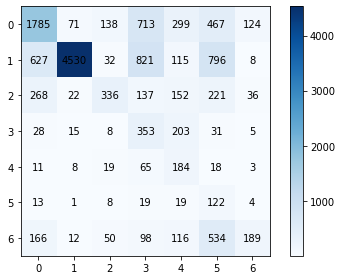

Normalized by true


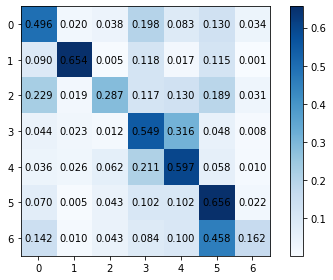

Normalized by prediction


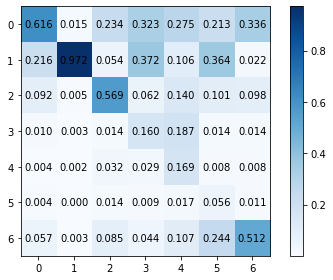

Num of layers: 1
Layer of size: 608 with dropout rate of 0.29593807406600897.
With a learning rate of 0.000540334492254627.
With 10 layers unfrozen.
And a batch size of 8.
---
Epoch 1/5
8750/8750 [==============================] - 613s 69ms/step - loss: 1.7650 - val_loss: 1.5378
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.5528
 — val_f1: 0.29934 — val_precision: 0.41633 — val_recall: 0.37464 — 
              precision    recall  f1-score   support

     neutral      0.645     0.325     0.432      3597
       happy      0.965     0.563     0.711      6929
         sad      0.312     0.351     0.330      1172
    surprise      0.198     0.401     0.265       643
        fear      0.282     0.273     0.277       308
     disgust      0.025     0.694     0.048       186
       angry      0.487     0.016     0.032      1165

    accuracy                          0.426     14000
   macro avg      0.416     0.375     0.299     14000
weighted 

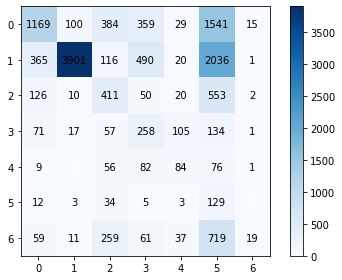

Normalized by true


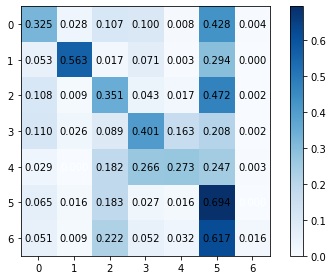

Normalized by prediction


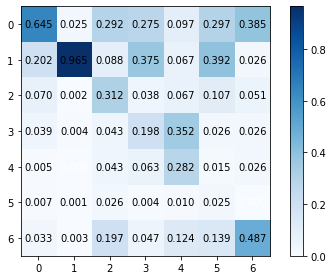

Epoch 2/5
8750/8750 [==============================] - 605s 69ms/step - loss: 1.4795 - val_loss: 1.1641
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.1691
 — val_f1: 0.36227 — val_precision: 0.44191 — val_recall: 0.42511 — 
              precision    recall  f1-score   support

     neutral      0.687     0.296     0.414      3597
       happy      0.885     0.842     0.863      6929
         sad      0.260     0.603     0.364      1172
    surprise      0.390     0.397     0.393       643
        fear      0.354     0.240     0.286       308
     disgust      0.046     0.522     0.085       186
       angry      0.471     0.076     0.130      1165

    accuracy                          0.580     14000
   macro avg      0.442     0.425     0.362     14000
weighted avg      0.702     0.580     0.600     14000

Non-normalized


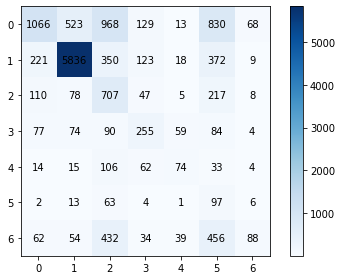

Normalized by true


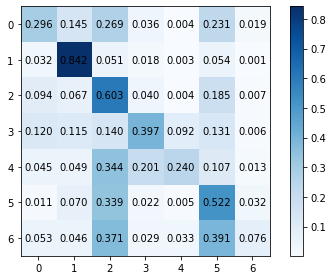

Normalized by prediction


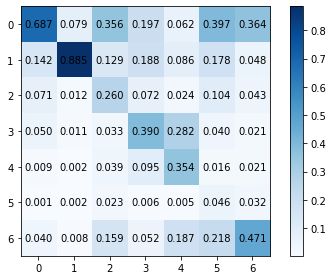

Epoch 3/5
8750/8750 [==============================] - 604s 69ms/step - loss: 1.3781 - val_loss: 1.1707
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1733
 — val_f1: 0.36773 — val_precision: 0.44384 — val_recall: 0.45265 — 
              precision    recall  f1-score   support

     neutral      0.760     0.188     0.301      3597
       happy      0.872     0.866     0.869      6929
         sad      0.401     0.439     0.419      1172
    surprise      0.277     0.456     0.345       643
        fear      0.272     0.347     0.305       308
     disgust      0.042     0.699     0.080       186
       angry      0.482     0.173     0.255      1165

    accuracy                          0.566     14000
   macro avg      0.444     0.453     0.368     14000
weighted avg      0.720     0.566     0.587     14000

Non-normalized


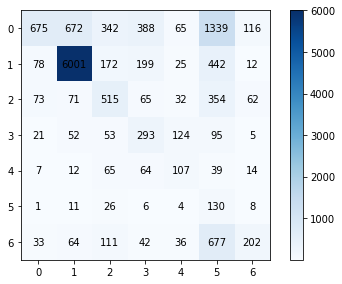

Normalized by true


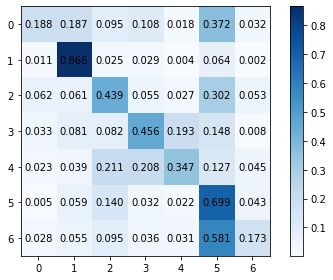

Normalized by prediction


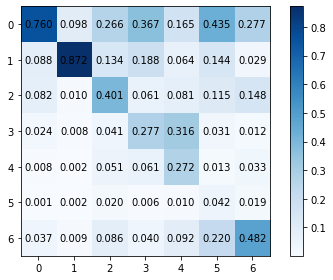

Epoch 4/5
8750/8750 [==============================] - 604s 69ms/step - loss: 1.3246 - val_loss: 1.0687
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0602
 — val_f1: 0.43626 — val_precision: 0.44034 — val_recall: 0.52342 — 
              precision    recall  f1-score   support

     neutral      0.633     0.520     0.571      3597
       happy      0.958     0.737     0.833      6929
         sad      0.384     0.499     0.434      1172
    surprise      0.187     0.594     0.285       643
        fear      0.247     0.422     0.311       308
     disgust      0.112     0.538     0.185       186
       angry      0.561     0.355     0.435      1165

    accuracy                          0.613     14000
   macro avg      0.440     0.523     0.436     14000
weighted avg      0.731     0.613     0.654     14000

Non-normalized


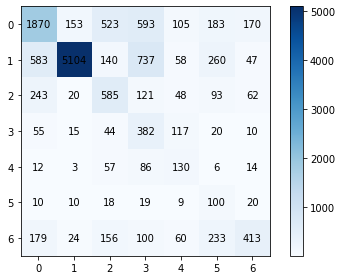

Normalized by true


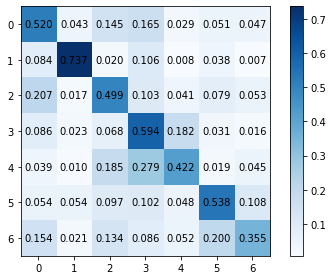

Normalized by prediction


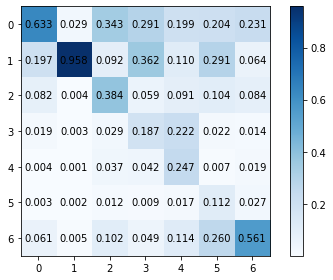

Epoch 5/5
8750/8750 [==============================] - 605s 69ms/step - loss: 1.2745 - val_loss: 0.9914
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 0.9850
 — val_f1: 0.42611 — val_precision: 0.44911 — val_recall: 0.52525 — 
              precision    recall  f1-score   support

     neutral      0.651     0.539     0.590      3597
       happy      0.939     0.813     0.871      6929
         sad      0.425     0.279     0.337      1172
    surprise      0.333     0.392     0.360       643
        fear      0.230     0.575     0.328       308
     disgust      0.072     0.790     0.132       186
       angry      0.495     0.288     0.364      1165

    accuracy                          0.629     14000
   macro avg      0.449     0.525     0.426     14000
weighted avg      0.730     0.629     0.667     14000

Non-normalized


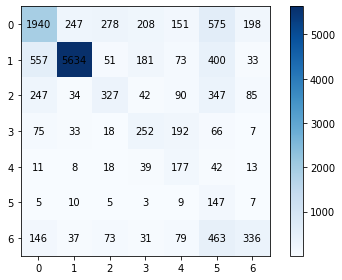

Normalized by true


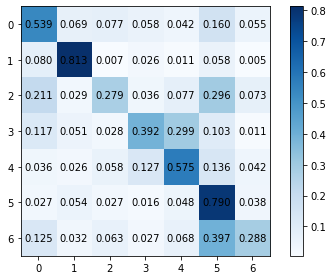

Normalized by prediction


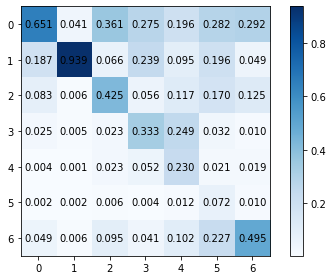

Num of layers: 2
Layer of size: 1496 with dropout rate of 0.7.
Layer of size: 1805 with dropout rate of 0.297553348670949.
With a learning rate of 1.717469415008396e-05.
With 19 layers unfrozen.
And a batch size of 32.
---
Epoch 1/5
2188/2188 [==============================] - 471s 212ms/step - loss: 1.9420 - val_loss: 1.4944
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.5006
 — val_f1: 0.27720 — val_precision: 0.29990 — val_recall: 0.34947 — 
              precision    recall  f1-score   support

     neutral      0.560     0.198     0.293      3597
       happy      0.821     0.675     0.741      6929
         sad      0.202     0.192     0.197      1172
    surprise      0.144     0.515     0.225       643
        fear      0.091     0.338     0.143       308
     disgust      0.042     0.215     0.070       186
       angry      0.239     0.314     0.271      1165

    accuracy                          0.461     14000
   macro avg   

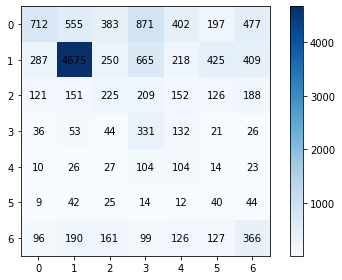

Normalized by true


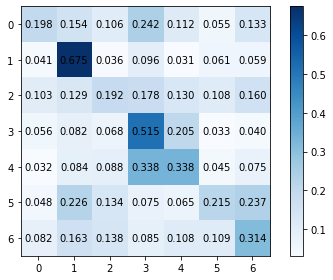

Normalized by prediction


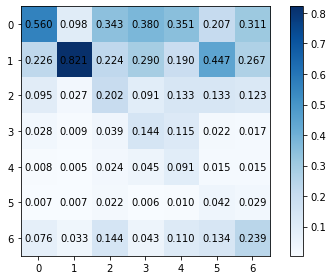

Epoch 2/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.6534 - val_loss: 1.1904
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.1964
 — val_f1: 0.37500 — val_precision: 0.36511 — val_recall: 0.44483 — 
              precision    recall  f1-score   support

     neutral      0.598     0.459     0.519      3597
       happy      0.911     0.752     0.824      6929
         sad      0.257     0.283     0.270      1172
    surprise      0.214     0.376     0.273       643
        fear      0.164     0.490     0.246       308
     disgust      0.086     0.366     0.139       186
       angry      0.325     0.387     0.354      1165

    accuracy                          0.579     14000
   macro avg      0.365     0.445     0.375     14000
weighted avg      0.668     0.579     0.613     14000

Non-normalized


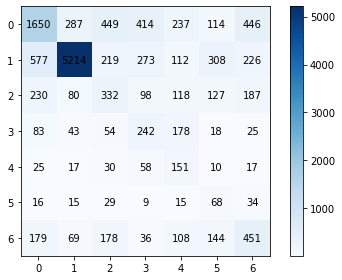

Normalized by true


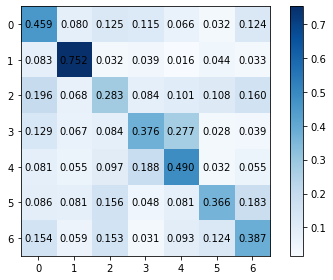

Normalized by prediction


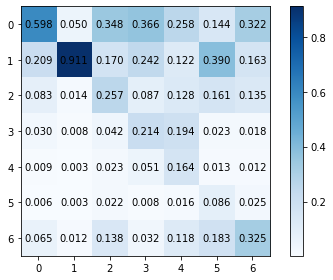

Epoch 3/5
2188/2188 [==============================] - 464s 212ms/step - loss: 1.5112 - val_loss: 1.1100
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.1117
 — val_f1: 0.40314 — val_precision: 0.39169 — val_recall: 0.48066 — 
              precision    recall  f1-score   support

     neutral      0.605     0.518     0.558      3597
       happy      0.940     0.746     0.832      6929
         sad      0.287     0.314     0.300      1172
    surprise      0.239     0.465     0.316       643
        fear      0.199     0.458     0.278       308
     disgust      0.089     0.468     0.149       186
       angry      0.382     0.397     0.389      1165

    accuracy                          0.599     14000
   macro avg      0.392     0.481     0.403     14000
weighted avg      0.693     0.599     0.635     14000

Non-normalized


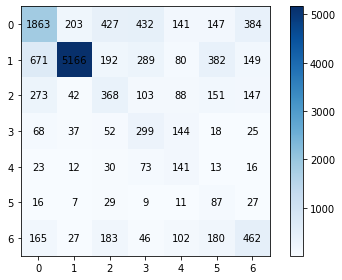

Normalized by true


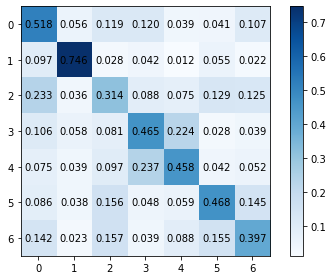

Normalized by prediction


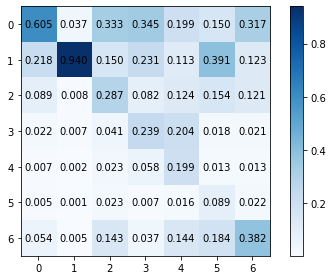

Epoch 4/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.3996 - val_loss: 1.1859
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.1811
 — val_f1: 0.39784 — val_precision: 0.39054 — val_recall: 0.49567 — 
              precision    recall  f1-score   support

     neutral      0.617     0.456     0.525      3597
       happy      0.961     0.692     0.805      6929
         sad      0.301     0.385     0.338      1172
    surprise      0.241     0.437     0.311       643
        fear      0.197     0.519     0.285       308
     disgust      0.074     0.522     0.129       186
       angry      0.343     0.458     0.392      1165

    accuracy                          0.569     14000
   macro avg      0.391     0.496     0.398     14000
weighted avg      0.704     0.569     0.616     14000

Non-normalized


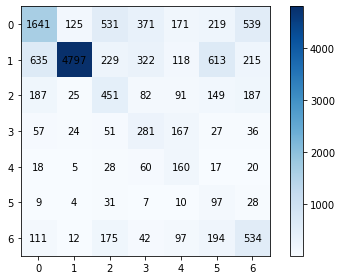

Normalized by true


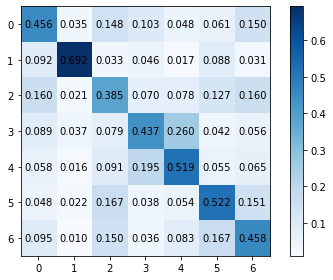

Normalized by prediction


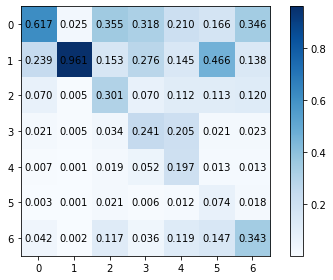

Epoch 5/5
2188/2188 [==============================] - 463s 212ms/step - loss: 1.3288 - val_loss: 1.0722
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.0611
 — val_f1: 0.42885 — val_precision: 0.41299 — val_recall: 0.52153 — 
              precision    recall  f1-score   support

     neutral      0.635     0.455     0.530      3597
       happy      0.950     0.749     0.838      6929
         sad      0.319     0.489     0.386      1172
    surprise      0.257     0.532     0.347       643
        fear      0.224     0.500     0.309       308
     disgust      0.104     0.484     0.171       186
       angry      0.402     0.442     0.421      1165

    accuracy                          0.607     14000
   macro avg      0.413     0.522     0.429     14000
weighted avg      0.712     0.607     0.643     14000

Non-normalized


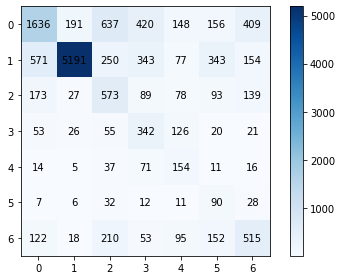

Normalized by true


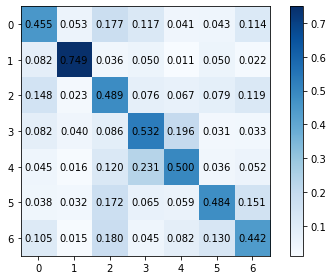

Normalized by prediction


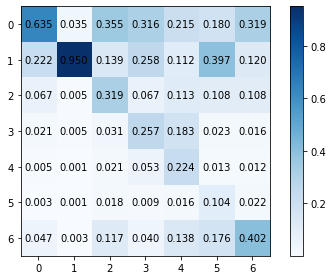

Num of layers: 1
Layer of size: 64 with dropout rate of 0.0.
With a learning rate of 0.001.
With 10 layers unfrozen.
And a batch size of 64.
---
Epoch 1/5
1094/1094 [==============================] - 451s 407ms/step - loss: 1.6366 - val_loss: 0.9394
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 0.9353
 — val_f1: 0.43064 — val_precision: 0.44445 — val_recall: 0.48107 — 
              precision    recall  f1-score   support

     neutral      0.618     0.681     0.648      3597
       happy      0.907     0.840     0.872      6929
         sad      0.466     0.212     0.292      1172
    surprise      0.296     0.459     0.360       643
        fear      0.204     0.448     0.280       308
     disgust      0.111     0.414     0.175       186
       angry      0.510     0.313     0.388      1165

    accuracy                          0.671     14000
   macro avg      0.444     0.481     0.431     14000
weighted avg      0.709     0.671     0

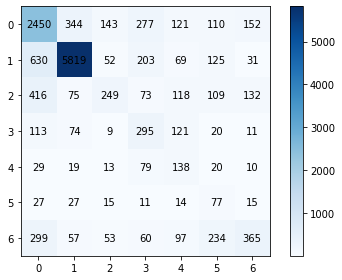

Normalized by true


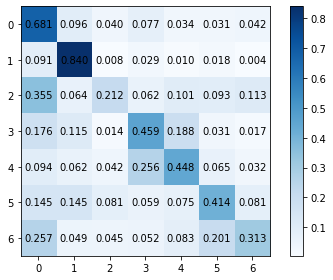

Normalized by prediction


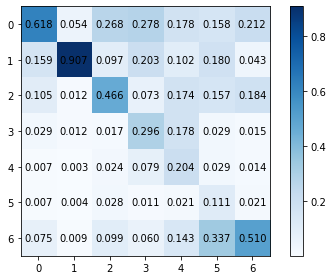

Epoch 2/5
1094/1094 [==============================] - 443s 405ms/step - loss: 1.3207 - val_loss: 1.3737
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.3693
 — val_f1: 0.36050 — val_precision: 0.41052 — val_recall: 0.49007 — 
              precision    recall  f1-score   support

     neutral      0.666     0.352     0.461      3597
       happy      0.965     0.646     0.774      6929
         sad      0.483     0.327     0.390      1172
    surprise      0.145     0.387     0.211       643
        fear      0.134     0.662     0.223       308
     disgust      0.054     0.737     0.100       186
       angry      0.428     0.319     0.366      1165

    accuracy                          0.506     14000
   macro avg      0.411     0.490     0.361     14000
weighted avg      0.735     0.506     0.580     14000

Non-normalized


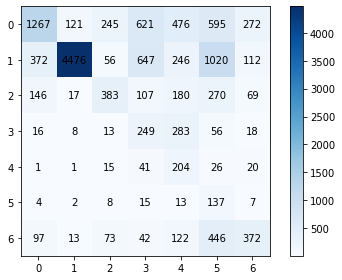

Normalized by true


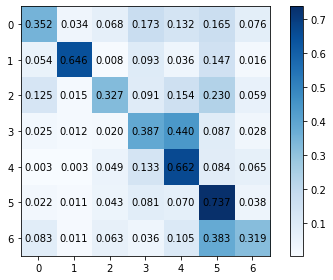

Normalized by prediction


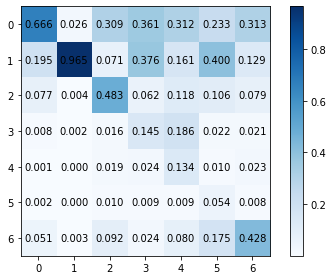

Epoch 3/5
1094/1094 [==============================] - 443s 405ms/step - loss: 1.2192 - val_loss: 1.3143
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.3028
 — val_f1: 0.37057 — val_precision: 0.42371 — val_recall: 0.48393 — 
              precision    recall  f1-score   support

     neutral      0.738     0.220     0.340      3597
       happy      0.904     0.713     0.797      6929
         sad      0.227     0.723     0.346      1172
    surprise      0.218     0.502     0.304       643
        fear      0.166     0.510     0.250       308
     disgust      0.106     0.435     0.170       186
       angry      0.606     0.284     0.387      1165

    accuracy                          0.534     14000
   macro avg      0.424     0.484     0.371     14000
weighted avg      0.722     0.534     0.565     14000

Non-normalized


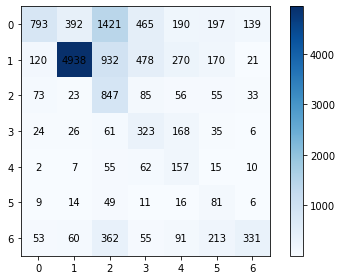

Normalized by true


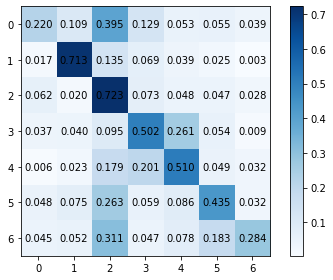

Normalized by prediction


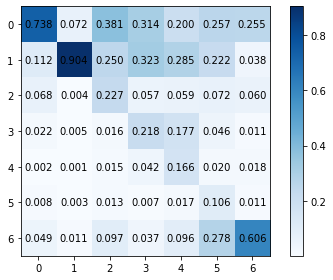

Epoch 4/5
1094/1094 [==============================] - 444s 406ms/step - loss: 1.1812 - val_loss: 0.9468
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 0.9319
 — val_f1: 0.46162 — val_precision: 0.47187 — val_recall: 0.53672 — 
              precision    recall  f1-score   support

     neutral      0.638     0.623     0.631      3597
       happy      0.946     0.752     0.838      6929
         sad      0.483     0.403     0.439      1172
    surprise      0.319     0.499     0.389       643
        fear      0.327     0.412     0.365       308
     disgust      0.073     0.688     0.132       186
       angry      0.517     0.379     0.438      1165

    accuracy                          0.639     14000
   macro avg      0.472     0.537     0.462     14000
weighted avg      0.739     0.639     0.678     14000

Non-normalized


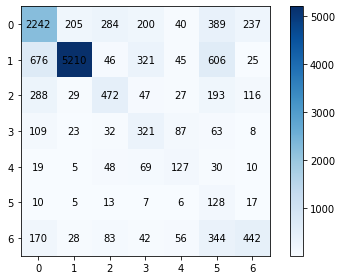

Normalized by true


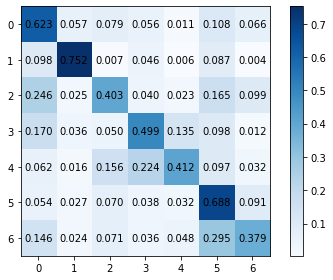

Normalized by prediction


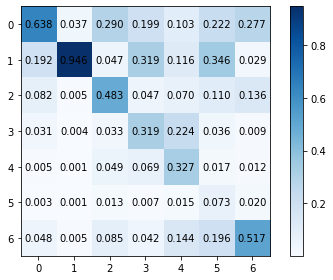

Epoch 5/5
1094/1094 [==============================] - 444s 406ms/step - loss: 1.1553 - val_loss: 1.1236
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.0998
 — val_f1: 0.40996 — val_precision: 0.47211 — val_recall: 0.50471 — 
              precision    recall  f1-score   support

     neutral      0.686     0.394     0.500      3597
       happy      0.946     0.774     0.851      6929
         sad      0.618     0.281     0.386      1172
    surprise      0.250     0.631     0.359       643
        fear      0.240     0.409     0.303       308
     disgust      0.047     0.742     0.089       186
       angry      0.516     0.302     0.381      1165

    accuracy                          0.581     14000
   macro avg      0.472     0.505     0.410     14000
weighted avg      0.757     0.581     0.638     14000

Non-normalized


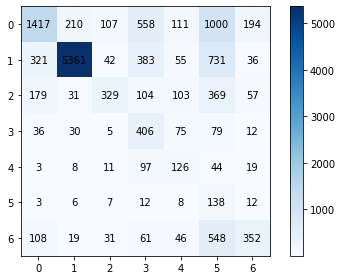

Normalized by true


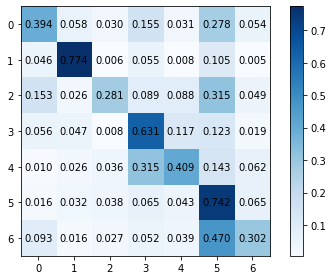

Normalized by prediction


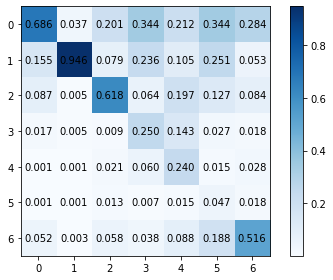

Num of layers: 1
Layer of size: 732 with dropout rate of 0.4298942438302507.
With a learning rate of 1e-05.
With 10 layers unfrozen.
And a batch size of 8.
---
Epoch 1/5
8750/8750 [==============================] - 613s 69ms/step - loss: 1.8887 - val_loss: 1.4459
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.4512
 — val_f1: 0.31533 — val_precision: 0.31944 — val_recall: 0.38949 — 
              precision    recall  f1-score   support

     neutral      0.527     0.390     0.448      3597
       happy      0.920     0.606     0.730      6929
         sad      0.211     0.258     0.232      1172
    surprise      0.143     0.300     0.194       643
        fear      0.110     0.565     0.185       308
     disgust      0.066     0.188     0.098       186
       angry      0.258     0.420     0.320      1165

    accuracy                          0.485     14000
   macro avg      0.319     0.389     0.315     14000
weighted avg      0.640  

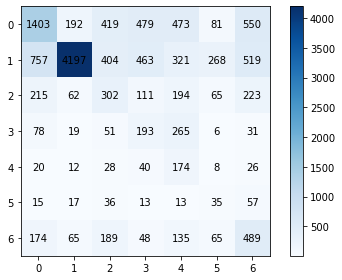

Normalized by true


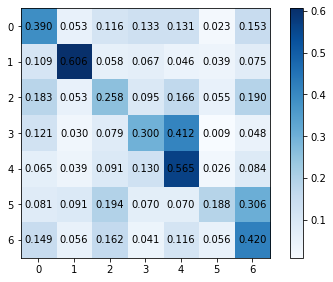

Normalized by prediction


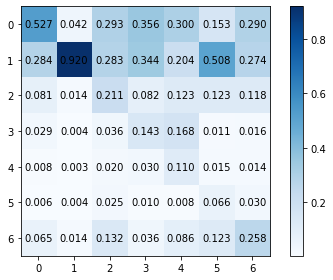

Epoch 2/5
8750/8750 [==============================] - 606s 69ms/step - loss: 1.6050 - val_loss: 1.2172
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.2218
 — val_f1: 0.38320 — val_precision: 0.37341 — val_recall: 0.46510 — 
              precision    recall  f1-score   support

     neutral      0.580     0.506     0.540      3597
       happy      0.951     0.684     0.796      6929
         sad      0.272     0.335     0.300      1172
    surprise      0.216     0.378     0.275       643
        fear      0.148     0.571     0.235       308
     disgust      0.093     0.349     0.147       186
       angry      0.354     0.432     0.389      1165

    accuracy                          0.567     14000
   macro avg      0.373     0.465     0.383     14000
weighted avg      0.686     0.567     0.610     14000

Non-normalized


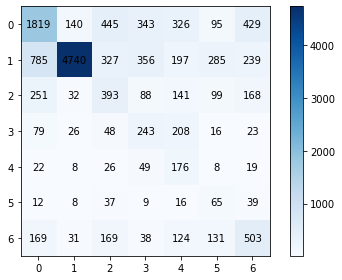

Normalized by true


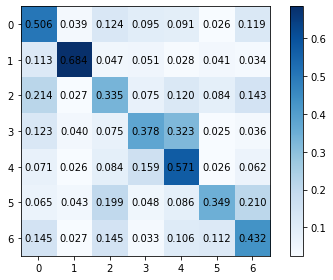

Normalized by prediction


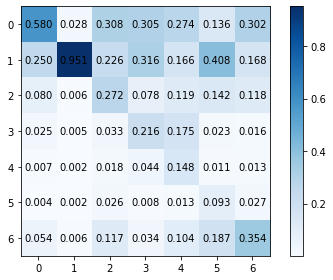

Epoch 3/5
8750/8750 [==============================] - 607s 69ms/step - loss: 1.4607 - val_loss: 1.1189
Calculating training loss
1094/1094 [==============================] - 82s 74ms/step - loss: 1.1206
 — val_f1: 0.40860 — val_precision: 0.39618 — val_recall: 0.49804 — 
              precision    recall  f1-score   support

     neutral      0.605     0.521     0.560      3597
       happy      0.955     0.726     0.825      6929
         sad      0.322     0.354     0.337      1172
    surprise      0.231     0.423     0.299       643
        fear      0.175     0.555     0.267       308
     disgust      0.100     0.473     0.164       186
       angry      0.385     0.434     0.408      1165

    accuracy                          0.597     14000
   macro avg      0.396     0.498     0.409     14000
weighted avg      0.703     0.597     0.636     14000

Non-normalized


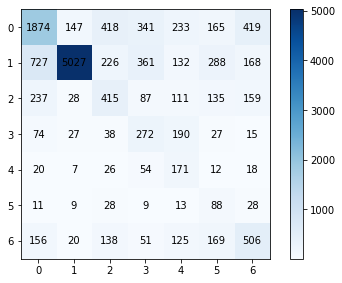

Normalized by true


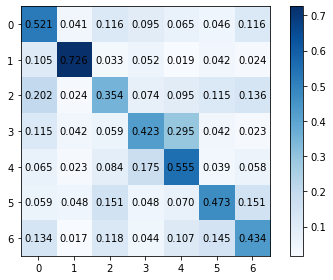

Normalized by prediction


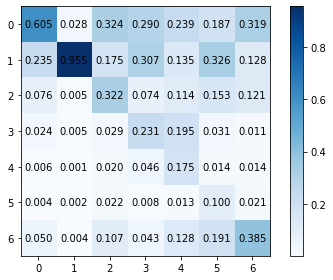

Epoch 4/5
8750/8750 [==============================] - 617s 70ms/step - loss: 1.3839 - val_loss: 1.1051
Calculating training loss
1094/1094 [==============================] - 83s 76ms/step - loss: 1.0994
 — val_f1: 0.42931 — val_precision: 0.41166 — val_recall: 0.51567 — 
              precision    recall  f1-score   support

     neutral      0.606     0.529     0.565      3597
       happy      0.964     0.709     0.817      6929
         sad      0.361     0.422     0.389      1172
    surprise      0.212     0.518     0.300       643
        fear      0.180     0.542     0.271       308
     disgust      0.147     0.398     0.215       186
       angry      0.412     0.492     0.448      1165

    accuracy                          0.604     14000
   macro avg      0.412     0.516     0.429     14000
weighted avg      0.713     0.604     0.642     14000

Non-normalized


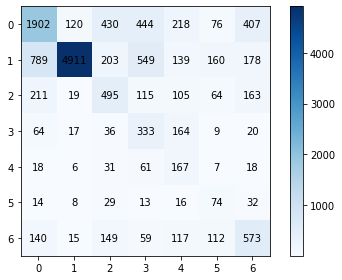

Normalized by true


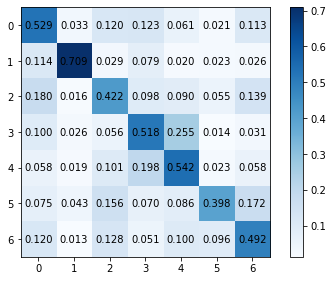

Normalized by prediction


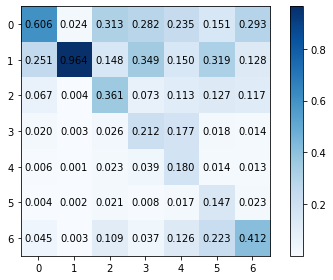

Epoch 5/5
8750/8750 [==============================] - 606s 69ms/step - loss: 1.3072 - val_loss: 1.1026
Calculating training loss
1094/1094 [==============================] - 80s 73ms/step - loss: 1.0957
 — val_f1: 0.42642 — val_precision: 0.41253 — val_recall: 0.52970 — 
              precision    recall  f1-score   support

     neutral      0.622     0.497     0.552      3597
       happy      0.963     0.712     0.819      6929
         sad      0.373     0.448     0.407      1172
    surprise      0.263     0.456     0.333       643
        fear      0.171     0.565     0.263       308
     disgust      0.099     0.527     0.167       186
       angry      0.397     0.504     0.444      1165

    accuracy                          0.600     14000
   macro avg      0.413     0.530     0.426     14000
weighted avg      0.718     0.600     0.641     14000

Non-normalized


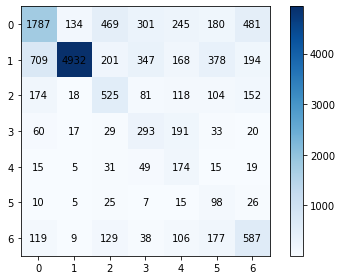

Normalized by true


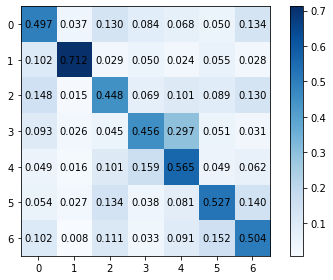

Normalized by prediction


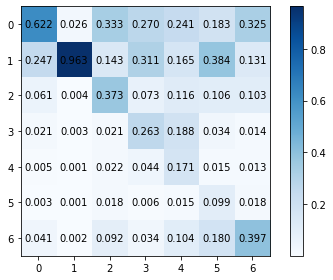

Num of layers: 1
Layer of size: 1197 with dropout rate of 0.0.
With a learning rate of 0.00021988801230394696.
With 16 layers unfrozen.
And a batch size of 4.
---
Epoch 1/5
17500/17500 [==============================] - 808s 46ms/step - loss: 1.7127 - val_loss: 1.2713
Calculating training loss
1094/1094 [==============================] - 81s 74ms/step - loss: 1.2760
 — val_f1: 0.36502 — val_precision: 0.41729 — val_recall: 0.44790 — 
              precision    recall  f1-score   support

     neutral      0.640     0.404     0.495      3597
       happy      0.932     0.712     0.807      6929
         sad      0.318     0.434     0.367      1172
    surprise      0.236     0.294     0.262       643
        fear      0.170     0.503     0.254       308
     disgust      0.040     0.591     0.075       186
       angry      0.586     0.197     0.294      1165

    accuracy                          0.541     14000
   macro avg      0.417     0.448     0.365     14000
weighted avg      0.

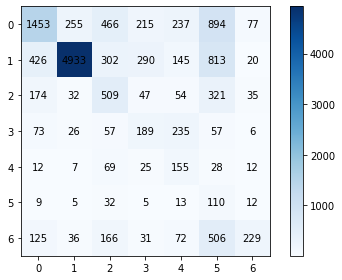

Normalized by true


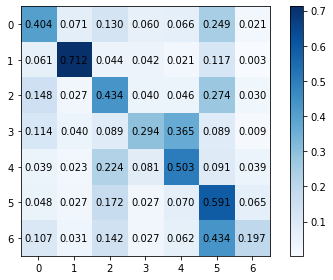

Normalized by prediction


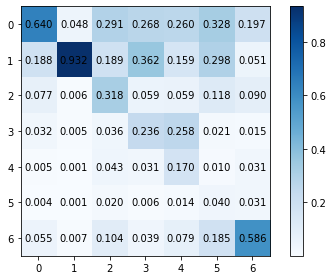

Epoch 2/5
17500/17500 [==============================] - 806s 46ms/step - loss: 1.3790 - val_loss: 1.0247
Calculating training loss
1094/1094 [==============================] - 82s 75ms/step - loss: 1.0231
 — val_f1: 0.43583 — val_precision: 0.45392 — val_recall: 0.50676 — 
              precision    recall  f1-score   support

     neutral      0.638     0.608     0.622      3597
       happy      0.927     0.795     0.856      6929
         sad      0.367     0.531     0.434      1172
    surprise      0.259     0.468     0.334       643
        fear      0.257     0.464     0.331       308
     disgust      0.106     0.484     0.174       186
       angry      0.623     0.197     0.300      1165

    accuracy                          0.649     14000
   macro avg      0.454     0.507     0.436     14000
weighted avg      0.724     0.649     0.670     14000

Non-normalized


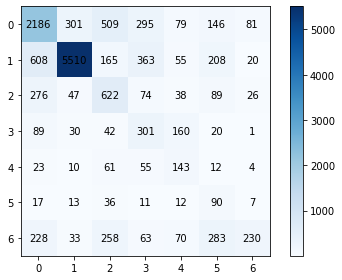

Normalized by true


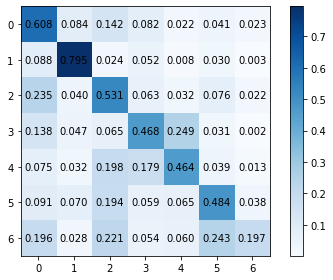

Normalized by prediction


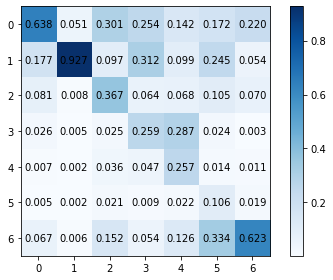

Epoch 3/5
10215/17500 [================>.............] - ETA: 5:29 - loss: 1.3206

KeyboardInterrupt: 

In [59]:
search_space = list();
search_space.append(Integer(1, 4, name='num_layers'))
search_space.append(Integer(64, 2048, name='layer1_size'))
search_space.append(Integer(64, 2048, name='layer2_size'))
search_space.append(Integer(64, 2048, name='layer3_size'))
search_space.append(Real(0.0, 0.7, name='dropout1_rate'))
search_space.append(Real(0.0, 0.7, name='dropout2_rate'))
search_space.append(Real(0.0, 0.7, name='dropout3_rate'))
search_space.append(Real(1e-5, 1e-3, 'log-uniform', name='learning_rate'))
search_space.append(Integer(10, 30, name='num_layers_to_unfreeze'))
search_space.append(Integer(2, 6, name='batch_size_log_2'))

checkpoint_fname = "checkpoints/checkpoint.pkl"
checkpoint_saver = CheckpointSaver(checkpoint_fname, compress=9)

def print_hyperparameters(layer_sizes, dropout_rates, learning_rate, num_layers_to_unfreeze, batch_size):
    print("Num of layers: {}".format(len(layer_sizes)))
    for l_size, do_rate in zip(layer_sizes, dropout_rates):
        print(colored("Layer of size: {} with dropout rate of {}.".format(l_size, do_rate), attrs=["bold"]))
    print(colored("With a learning rate of {}.".format(learning_rate), attrs=["bold"]))
    print(colored("With {} layers unfrozen.".format(num_layers_to_unfreeze), attrs=["bold"]))
    print(colored("And a batch size of {}.".format(batch_size), attrs=["bold"]))
    print("---")

def save_history(save_dir, hist, layer_sizes, dropout_rates, learning_rate, num_layers_to_unfreeze, batch_size):
    with open(os.path.join(save_dir, "hist.txt"), "w") as f:
        f.write(str(hist.history))
    with open(os.path.join(save_dir, "params.txt"), "w") as f:
        f.write("Layer sizes: " + str(layer_sizes) + "\n")
        f.write("Dropout rates: " + str(dropout_rates) + "\n")
        f.write("Learning rate: " + str(learning_rate) + "\n")
        f.write("Num layers unfrozen: " + str(num_layers_to_unfreeze) + "\n")
        f.write("batch_size: " + str(batch_size) + "\n")
    
@use_named_args(search_space)
def evaluate_model(**params):
    num_layers = params["num_layers"]
    layer1_size = params["layer1_size"]
    layer2_size = params["layer2_size"]
    layer3_size = params["layer3_size"]
    dropout1_rate = params["dropout1_rate"]
    dropout2_rate = params["dropout2_rate"]
    dropout3_rate = params["dropout3_rate"]
    learning_rate = params["learning_rate"]
    num_layers_to_unfreeze = params["num_layers_to_unfreeze"]
    batch_size = 2 ** params["batch_size_log_2"]
    
    layer_sizes = [layer1_size, layer2_size, layer3_size][:num_layers]
    dropout_rates = [dropout1_rate, dropout2_rate, dropout3_rate][:num_layers]
    
    print_hyperparameters(layer_sizes, dropout_rates, learning_rate, num_layers_to_unfreeze, batch_size)
    
    model = build_model_pretrained(layer_sizes, dropout_rates)
    model = unfreeze_model(model, num_layers_to_unfreeze)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy"
    )
    
    train_ds = read_dataset(batch_size, train_tfrecord_paths, map_funcs=map_funcs)
    
    steps_per_epoch = math.ceil(train_ds_num_of_imgs / batch_size) # One full epoch
    
    metrics = Metrics(valid_data=val_ds)
    now = datetime.datetime.now()
    date_str = now.strftime("%m-%d-%Y_%H:%M:%S")
    save_dir = os.path.join("checkpoints", date_str)
    os.makedirs(save_dir)
    metrics.save_dir = save_dir
    
    model_history = model.fit(train_ds, epochs=5, steps_per_epoch=steps_per_epoch, class_weight=class_weight, validation_data=val_ds, verbose=1, batch_size=batch_size, callbacks=[metrics])
    
    save_history(save_dir, model_history, layer_sizes, dropout_rates, learning_rate, num_layers_to_unfreeze, batch_size)

    return min(model_history.history["val_loss"])

result = gp_minimize(evaluate_model, search_space, callback=[checkpoint_saver], random_state=3)


In [57]:
with_self_sup_model = load_model("/mnt/HDD/AUB/CMPS287/Project/Facial Emotion Recognition/final_model/self_supervised/model_4_0.8455620408058167.h5", custom_objects={"Swish": Swish, "SoftmaxCosineSim": SoftmaxCosineSim})

with_self_sup_model.evaluate(test_ds)

2625/2625 [==============================] - 39s 15ms/step - loss: 0.8599


0.8598533272743225

In [59]:
without_self_sup_model = load_model("/mnt/HDD/AUB/CMPS287/Project/Facial Emotion Recognition/final_model/without_self_supervised/model_6_0.862356960773468.h5", custom_objects={"Swish": Swish, "SoftmaxCosineSim": SoftmaxCosineSim})

without_self_sup_model.evaluate(test_ds)

2625/2625 [==============================] - 40s 15ms/step - loss: 0.8653


0.8652890920639038